In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Load and harmonized data

In [2]:
ls /Users/jacobv/Science/AllenStuff/HumanCells/

matrix.csv         taxonomy.txt*      trimmed_means.csv
metadata.csv       taxonomy.zip       tsne.csv


In [2]:
df = pandas.read_csv('/Users/jacobv/Science/AllenStuff/HumanCells/trimmed_means.csv',
                    index_col=0)
df.head()

,Exc L5-6 FEZF2 ANKRD20A1,Exc L5-6 THEMIS TMEM233,Inh L1 LAMP5 NDNF,Exc L6 FEZF2 CPZ,Astro L1 FGFR3 MT1G,Exc L2-3 LINC00507 RPL9P17,Exc L6 FEZF2 KRT17,Exc L3-4 RORB FOLH1B,Endo L2-5 CLDN5,Exc L5-6 RORB LINC00320,...,Exc L4 RORB CACNG5,Exc L6 FEZF2 FAM95C,Inh L1-3 VIP GGH,Exc L3-5 FEZF2 DCN,Exc L6 FEZF2 ETV4,Exc L5-6 FEZF2 RSAD2,Inh L1 ADARB2 DISP2,Inh L5-6 LAMP5 SFTA3,Exc L6 FEZF2 TBC1D26,Inh L4-5 PVALB TRIM67
feature,,,,,,,,,,,,,,,,,,,,,
3.8-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HT3C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
comps = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/PLS_Component_Expr.csv')
comps.index = comps.gene_symbol.values
comps.head()

,gene_symbol,gene_name,C1_expr,C2_expr,C3_expr
A1BG,A1BG,alpha-1-B glycoprotein,0.001517,0.006065,-0.020001
A1BG-AS1,A1BG-AS1,NaN,-0.006685,-0.006733,-0.002762
A2M,A2M,alpha-2-macroglobulin,0.005135,0.007225,0.002345
A2ML1,A2ML1,alpha-2-macroglobulin-like 1,-0.009261,-0.004295,-0.010945
A3GALT2,A3GALT2,NaN,-0.001305,-0.000388,-0.000463


In [4]:
shared = list(set(comps.index) & set(df.index))

In [5]:
comps = comps.loc[shared]
df = df.loc[shared]

In [4]:
from difflib import get_close_matches

In [5]:
ebps = get_close_matches('C9orf72',df.index)

In [6]:
ebps

['C9orf72', 'C9orf172', 'C9orf92']

In [7]:
from sklearn.preprocessing import MinMaxScaler
jnk = MinMaxScaler().fit_transform(df.values)
mmdf = pandas.DataFrame(jnk,index=df.index,columns=df.columns).T

In [31]:
sorted(mmdf.index.tolist())

['Astro L1 FGFR3 FOS',
 'Astro L1 FGFR3 MT1G',
 'Astro L1-6 FGFR3 ETNPPL',
 'Endo L2-5 CLDN5',
 'Exc L2-3 LINC00507 RPL9P17',
 'Exc L2-4 RORB GRIK1',
 'Exc L3 LINC00507 CTXN3',
 'Exc L3 LINC00507 PSRC1',
 'Exc L3 RORB CARTPT',
 'Exc L3 THEMIS PLA2G7',
 'Exc L3-4 RORB FOLH1B',
 'Exc L3-4 RORB PRSS12',
 'Exc L3-4 RORB RPS3P6',
 'Exc L3-4 RORB SEMA6D',
 'Exc L3-5 FEZF2 DCN',
 'Exc L3-5 FEZF2 ONECUT1',
 'Exc L3-5 LINC00507 SLN',
 'Exc L3-5 RORB CD24',
 'Exc L3-5 RORB CMAHP',
 'Exc L3-5 RORB HSPB3',
 'Exc L3-5 THEMIS ELOF1',
 'Exc L3-5 THEMIS UBE2F',
 'Exc L4 RORB BHLHE22',
 'Exc L4 RORB CACNG5',
 'Exc L4 RORB CCDC168',
 'Exc L4-5 RORB AIM2',
 'Exc L4-5 RORB ASCL1',
 'Exc L4-5 RORB HNRNPA1P46',
 'Exc L4-5 RORB LCN15',
 'Exc L4-5 RORB LINC01474',
 'Exc L4-5 RORB RPL31P31',
 'Exc L4-6 RORB HPCA',
 'Exc L5 FEZF2 DYRK2',
 'Exc L5 FEZF2 MORN2',
 'Exc L5 FEZF2 SCN7A',
 'Exc L5 RORB LINC01202',
 'Exc L5 RORB SNHG7',
 'Exc L5-6 FEZF2 ANKRD20A1',
 'Exc L5-6 FEZF2 CABP7',
 'Exc L5-6 FEZF2 CYP26B1',
 

In [13]:
ebps = [ebps[0]]
for ebp in ebps:
    mmdf.sort_values(ebp,ascending=True,inplace=True)
    mmdf.loc[:,'%s_rank'%ebp] = range(len(mmdf))

In [14]:
mmdf.shape

(121, 50282)

In [15]:
mmdf[ebps].loc['Micro L1-6 C1QC']

feature
C9orf172    0.0
Name: Micro L1-6 C1QC, dtype: float64

In [16]:
mmdf[ebps]

feature,C9orf172
Exc L5-6 FEZF2 ANKRD20A1,0.0
Exc L5-6 THEMIS TMEM233,0.0
Inh L1 LAMP5 NDNF,0.0
Exc L6 FEZF2 CPZ,0.0
Astro L1 FGFR3 MT1G,0.0
...,...
Exc L5-6 FEZF2 RSAD2,0.0
Inh L1 ADARB2 DISP2,0.0
Inh L5-6 LAMP5 SFTA3,0.0
Exc L6 FEZF2 TBC1D26,0.0


In [27]:
df.loc['C9orf72'].sort_values(ascending=False).head(40)

Exc L5 RORB LINC01202       6.278637
Exc L3-5 THEMIS ELOF1       6.252174
Exc L5-6 FEZF2 CABP7        6.010769
Exc L5-6 RORB LINC00320     6.004254
Exc L5 FEZF2 DYRK2          5.701765
Exc L3 THEMIS PLA2G7        5.672000
Exc L3-5 FEZF2 DCN          5.533571
Exc L3-4 RORB FOLH1B        5.409222
Exc L3 LINC00507 CTXN3      5.254752
Inh L1-3 PVALB WFDC2        5.253800
Exc L6 FEZF2 SLITRK6        5.241538
Exc L5 FEZF2 MORN2          5.203437
Exc L5 FEZF2 SCN7A          5.141364
Exc L6 FEZF2 TBCC           5.027703
Exc L5-6 FEZF2 CYP26B1      5.027200
Exc L3 RORB CARTPT          5.020726
Inh L2-4 PVALB C8orf4       4.913750
Exc L3-4 RORB PRSS12        4.821924
Exc L5 RORB SNHG7           4.803317
Exc L3-5 RORB HSPB3         4.720000
Exc L5-6 FEZF2 ANKRD20A1    4.708394
Exc L3-5 THEMIS UBE2F       4.698923
Exc L6 FEZF2 CPZ            4.662619
Exc L3-5 FEZF2 ONECUT1      4.635000
Exc L3-4 RORB SEMA6D        4.482627
Exc L4-5 RORB LCN15         4.305402
Exc L3-5 LINC00507 SLN      4.156428
I

In [28]:
df.loc['GRN'].sort_values(ascending=False).head(40)

Exc L6 FEZF2 TBCC           0.581182
Inh L1 VIP SOX11            0.545790
Inh L1-2 PAX6 SCGN          0.500800
Inh L6 SST NPY              0.453462
Inh L1 VIP TNFAIP8L3        0.367857
Exc L5 FEZF2 SCN7A          0.300303
Exc L5 RORB SNHG7           0.239414
Exc L6 FEZF2 CPZ            0.189055
Exc L3-5 THEMIS UBE2F       0.139381
Exc L5-6 THEMIS THTPA       0.125385
Exc L6 FEZF2 SLITRK6        0.101753
Inh L1-3 PAX6 NABP1         0.097692
Micro L1-6 C1QC             0.086406
Exc L6 FEZF2 P4HA3          0.078333
Inh L6 LAMP5 ANKRD20A11P    0.077143
Inh L1-2 VIP RPL41P3        0.071493
Exc L3-4 RORB FOLH1B        0.065830
Exc L3-5 THEMIS ELOF1       0.059000
Exc L5-6 FEZF2 ANKRD20A1    0.055268
Exc L6 FEZF2 KRT17          0.051644
Inh L1-3 VIP SSTR1          0.051111
Exc L6 FEZF2 TBC1D26        0.050984
Inh L5-6 SST TH             0.050000
Inh L1-3 VIP ACHE           0.041250
Exc L6 THEMIS C6orf48       0.040811
Exc L5-6 FEZF2 CABP7        0.026000
Inh L1-6 VIP RCN1           0.014595
E

In [20]:
df.loc[ebps].sort_values('C9orf72').head(40)

KeyError: 'C9orf72'

In [38]:
mmdf.loc['Micro L1-6 C1QC']

feature
MIER2             0.0
MYD88             0.0
OAZ3              0.0
RDH11             0.0
TTC16             0.0
                 ... 
TMEM167B          0.0
SRSF8             0.0
EIF4EBP1_rank    77.0
EIF4EBP2_rank     1.0
EIF4E1B_rank     27.0
Name: Micro L1-6 C1QC, Length: 15102, dtype: float64

# basic correlations

In [25]:
ctcomp = pandas.DataFrame(index=df.columns)
for i in range(1,4):
    print('working on component',i)
    ccol = 'C%s_expr'%i
    for ct in df.columns:
        r,p = stats.pearsonr(df[ct].values,comps[ccol].values)
        rho,rhop = stats.spearmanr(df[ct].values,comps[ccol].values)
        ctcomp.loc[ct,'C%s_r'%i] = r
        ctcomp.loc[ct,'C%s_p'%i] = p
        ctcomp.loc[ct,'C%s_rho'%i] = rho
        ctcomp.loc[ct,'C%s_rhop'%i] = rhop
    ctcomp.loc[:,'C%s_fdr'%i] = multipletests(ctcomp['C%s_p'%i].values,
                                              method='fdr_bh')[1]
    ctcomp.loc[:,'C%s_fdr_rho'%i] = multipletests(ctcomp['C%s_rhop'%i
                                                        ].values,
                                            method='fdr_bh')[1]

working on component 1
working on component 2
working on component 3


In [44]:
ctcomp.sort_values('C3_r')

,C1_r,C1_p,C1_rho,C1_rhop,C1_fdr,C1_fdr_rho,C2_r,C2_p,C2_rho,C2_rhop,C2_fdr,C2_fdr_rho,C3_r,C3_p,C3_rho,C3_rhop,C3_fdr,C3_fdr_rho
Exc L3 LINC00507 PSRC1,-0.197520,1.137518e-132,-0.202474,1.897981e-139,4.587990e-131,7.655191e-138,-0.109843,9.433052e-42,-0.127516,9.154249e-56,2.377915e-41,2.307634e-55,-0.050280,6.341606e-10,-0.053631,4.271933e-11,6.975766e-09,3.976184e-10
Exc L6 THEMIS C6orf48,-0.170275,1.338797e-98,-0.177293,7.292251e-107,5.785513e-98,3.529450e-106,-0.136041,2.738206e-63,-0.148190,7.018046e-75,1.004009e-62,2.497599e-74,-0.047745,4.365616e-09,-0.050674,4.657975e-10,3.521597e-08,3.315382e-09
Exc L3-5 LINC00507 SLN,-0.187748,7.866034e-120,-0.192181,1.437885e-125,1.189738e-118,2.174801e-124,-0.092876,2.755200e-30,-0.108887,4.704628e-41,5.291733e-30,9.035874e-41,-0.045149,2.853898e-08,-0.047410,5.594212e-09,2.031304e-07,3.760554e-08
Exc L5-6 THEMIS TMEM233,-0.177989,1.058299e-107,-0.181321,9.138988e-112,6.739692e-107,6.143431e-111,-0.117072,3.162985e-47,-0.131405,3.899827e-59,9.112410e-47,1.123522e-58,-0.043968,6.485562e-08,-0.044927,3.334219e-08,4.033191e-07,1.754089e-07
Exc L6 THEMIS LINC00343,-0.196289,5.152945e-131,-0.200927,2.594322e-137,1.558766e-129,7.847823e-136,-0.154690,1.666715e-81,-0.170655,4.882125e-99,1.061434e-80,3.692107e-98,-0.039255,1.400163e-06,-0.040054,8.510997e-07,6.516145e-06,3.551140e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Inh L5 PVALB CNTNAP3P2,-0.103081,5.979446e-37,-0.116071,1.901614e-46,7.950692e-37,3.240779e-46,-0.102728,1.043301e-36,-0.116142,1.675239e-46,2.295262e-36,3.435660e-46,0.057339,1.776830e-12,0.060563,9.475221e-14,4.299929e-11,1.910836e-12
Inh L5-6 PVALB STON2,-0.099471,1.634825e-34,-0.118108,4.851647e-48,1.958553e-34,9.172645e-48,-0.109028,3.714424e-41,-0.126440,7.512771e-55,8.988906e-41,1.855194e-54,0.069042,2.009917e-17,0.066213,3.810651e-16,6.080000e-16,1.152722e-14
Inh L2-4 PVALB C8orf4,-0.106040,5.168573e-39,-0.122699,9.823295e-52,7.445206e-39,2.014608e-51,-0.115979,2.239800e-46,-0.131787,1.796192e-59,6.302693e-46,5.433481e-59,0.070010,7.149008e-18,0.070391,4.736601e-18,2.883433e-16,1.910429e-16
Exc L3 THEMIS PLA2G7,-0.152620,2.312302e-79,-0.166664,1.739746e-94,6.358831e-79,5.847480e-94,-0.183048,6.659322e-114,-0.192216,1.290831e-125,1.647501e-112,2.603175e-124,0.080473,4.013707e-23,0.073266,1.983705e-19,2.428292e-21,1.200141e-17


<AxesSubplot:>

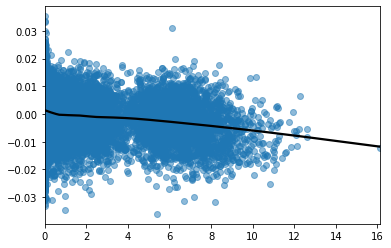

In [42]:
sns.regplot(x=df['Exc L6 THEMIS EGR3'].values,y=comps['C1_expr'].values,
           line_kws={'color':'k'},scatter_kws={'alpha':0.5})
x=

In [36]:
df[df['Exc L6 THEMIS EGR3']>1].shape

(5649, 121)

<AxesSubplot:ylabel='Count'>

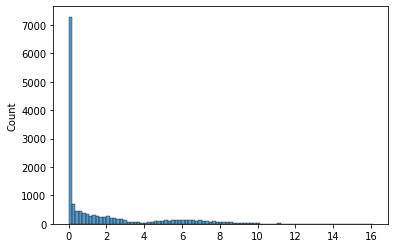

In [31]:
sns.histplot(df['Exc L6 THEMIS EGR3'].values)

# Tail correlations

# Enrichment

In [49]:
tm = pandas.read_csv('/Users/jacobv/Science/AllenStuff/HumanCells/trimmed_means.csv')

In [54]:
top_genes = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/PLSGXP_topgenes_list.csv',index_col=0)
top_genes.head()

,C2,C1,C3,tail
0,ME1,MET,MOGAT2,negative
1,KCNG1,DSP,KCNJ14,negative
2,MGAT4C,GRP,EFR3A,negative
3,NUPR1,FRAT1,PLCH1,negative
4,GPRIN2,IP6K2,PCDH12,negative


In [58]:
jnk

,feature,Exc L5-6 FEZF2 ANKRD20A1,rank
30786,MALAT1,16.126642,0
40474,ROBO2,12.953478,1
5018,CSMD1,12.890935,2
6228,DPP10,12.795108,3
38649,PTPRD,12.789130,4
...,...,...,...
20367,LOC105370434,0.000000,50276
20368,LOC105370435,0.000000,50277
20369,LOC105370436,0.000000,50278
20370,LOC105370437,0.000000,50279


In [61]:
col = tm.columns[1]
jnk = pandas.DataFrame(tm.sort_values(col,ascending=False),copy=True)[['feature',col]]
jnk.loc[:,'rank'] = range(len(jnk))
for comp in ['C1','C2','C3']:
    for tail in ['positive','negative']:
        glist = top_genes[top_genes['tail']==tail][comp].values
        print(comp,tail)
        mn = jnk[jnk.feature.isin(glist)]['rank'].mean()
        sd = jnk[jnk.feature.isin(glist)]['rank'].std()
        print('mean = %s (%s)'%(mn,sd) )
        

C1 positive
mean = 13010.676923076922 (12507.243333436387)
C1 negative
mean = 20584.438461538462 (11430.876877392484)
C2 positive
mean = 13475.469230769231 (11890.04282542829)
C2 negative
mean = 18332.302325581397 (12301.71763705978)
C3 positive
mean = 20531.361538461537 (12040.158196444449)
C3 negative
mean = 12642.108527131782 (11972.406754204847)


In [147]:
top_genes.head()

,C2,C1,C3,tail
0,ME1,MET,MOGAT2,negative
1,KCNG1,DSP,KCNJ14,negative
2,MGAT4C,GRP,EFR3A,negative
3,NUPR1,FRAT1,PLCH1,negative
4,GPRIN2,IP6K2,PCDH12,negative


In [148]:
overlap = pandas.DataFrame()
for c in ['C1','C2','C3']:
    for tail in ['negative','positive']:
        reflist = top_genes[top_genes['tail']==tail][c].values
        colnm = '%s_%s'%(c,tail[:3])
        for cell in tm.columns[1:]:
            glist = tm.sort_values(cell,ascending=False).head(130).feature.values
            overlap.loc[cell,colnm] = len(set(glist) & set(reflist))

In [164]:
noverlap = pandas.DataFrame()
for c in ['C1','C2','C3']:
    for tail in ['negative','positive']:
        colnm = '%s_%s'%(c,tail[:3])
        reflist = top_genes[top_genes['tail']==tail][c].values
        for i in range(1000):
            glist = np.random.choice(tm.feature.values,len(reflist),replace=False)
            noverlap.loc[i,colnm] = len(set(glist) & set(reflist))

In [179]:
50/6

8.333333333333334

In [181]:
for col in noverlap.columns:
    print(col,noverlap.sort_values(col).iloc[-8][col])

C1_neg 2.0
C1_pos 2.0
C2_neg 2.0
C2_pos 2.0
C3_neg 2.0
C3_pos 2.0


In [182]:
for col in noverlap.columns:
    cell_hits = overlap[overlap[col]>2].index
    print(col,cell_hits)

C1_neg Index([], dtype='object')
C1_pos Index(['Inh L1 LAMP5 NDNF', 'Exc L2-3 LINC00507 RPL9P17', 'Exc L6 FEZF2 KRT17',
       'Exc L3-4 RORB FOLH1B', 'Exc L5-6 RORB LINC00320',
       'Inh L1-4 VIP CHRNA2', 'Exc L5-6 FEZF2 CYP26B1',
       'Inh L1-6 PVALB SCUBE3', 'Exc L3-5 RORB CMAHP', 'Inh L1-3 VIP SSTR1',
       'Exc L3-5 LINC00507 SLN', 'Exc L4-5 RORB ASCL1', 'Inh L3-6 VIP KCTD13',
       'Inh L5-6 SST KLHL14', 'Exc L4-5 RORB HNRNPA1P46',
       'Exc L3-4 RORB SEMA6D', 'Inh L1 ADARB2 ADAM33', 'VLMC L1-3 CYP1B1',
       'Inh L1 PAX6 CA4', 'Inh L1-2 PVALB TAC1', 'Inh L5-6 SST ISOC1',
       'Exc L4 RORB BHLHE22', 'Inh L2-4 SST AHR', 'Exc L5 FEZF2 SCN7A',
       'Inh L2-4 VIP DSEL', 'Inh L6 LHX6 GLP1R', 'Exc L5-6 FEZF2 CABP7',
       'Inh L1-6 VIP RGS16', 'Exc L3-5 THEMIS ELOF1', 'Inh L3-5 SST MAFB',
       'Inh L5-6 SST TH', 'Exc L3 LINC00507 CTXN3', 'Exc L5-6 FEZF2 MYBPHL',
       'Exc L5 FEZF2 MORN2', 'Exc L3 LINC00507 PSRC1', 'Inh L1 SST CXCL14',
       'Exc L5 FEZF2 DYRK2', 'Exc

In [177]:
cellmeta = pandas.DataFrame(index = meta.groupby('cluster_label').subclass_label.first().index)
for cue in cues:
    cellmeta.loc[:,cue] = meta.groupby('cluster_label')[cue].first().values

In [209]:
overlap.drop('Unnamed: 26',axis=0,inplace=True)

In [210]:
for col in overlap.columns:
    cellmeta.loc[overlap[overlap[col]>2].index,'sigO_%s'%col] = 1
    cellmeta.loc[cellmeta['sigO_%s'%col]!=1,'sigO_%s'%col] = 0
        

In [214]:
for col in overlap.columns:
    print(col,'\n',cellmeta[cellmeta['sigO_%s'%col]==1].subclass_label.value_counts(),'\n')

C1_neg 
 IT     2
L6b    2
Name: subclass_label, dtype: int64 

C1_pos 
 IT         15
VIP         8
SST         5
L5/6 NP     5
L4 IT       4
PVALB       3
LAMP5       3
L5 ET       3
L6b         2
PAX6        1
VLMC        1
Name: subclass_label, dtype: int64 

C2_neg 
 VIP          18
IT            6
SST           6
LAMP5         6
L6b           5
PAX6          4
PVALB         3
Astrocyte     3
L6 CT         2
L5 ET         2
OPC           1
L5/6 NP       1
Microglia     1
VLMC          1
L4 IT         1
Name: subclass_label, dtype: int64 

C2_pos 
 L4 IT       6
L6 CT       3
IT          3
L6b         2
Pericyte    1
Name: subclass_label, dtype: int64 

C3_neg 
 IT         6
L6b        5
L5 ET      4
L5/6 NP    3
LAMP5      3
L4 IT      3
SST        2
L6 CT      1
Name: subclass_label, dtype: int64 

C3_pos 
 IT     2
L6b    2
Name: subclass_label, dtype: int64 



In [219]:
for col in overlap.columns:
    print(col,'\n',cellmeta[cellmeta['sigO_%s'%col]==1].class_label.value_counts(),'\n')

C1_neg 
 Glutamatergic    4
Name: class_label, dtype: int64 

C1_pos 
 Glutamatergic    29
GABAergic        20
Non-neuronal      1
Name: class_label, dtype: int64 

C2_neg 
 GABAergic        37
Glutamatergic    17
Non-neuronal      6
Name: class_label, dtype: int64 

C2_pos 
 Glutamatergic    14
Non-neuronal      1
Name: class_label, dtype: int64 

C3_neg 
 Glutamatergic    22
GABAergic         5
Name: class_label, dtype: int64 

C3_pos 
 Glutamatergic    4
Name: class_label, dtype: int64 



In [6]:
meta = pandas.read_csv('/Users/jacobv/Science/AllenStuff/HumanCells/metadata.csv')
meta

,sample_name,exp_component_name,specimen_type,cluster_color,cluster_order,cluster_label,class_color,class_order,class_label,subclass_color,...,cell_type_alt_alias_order,cell_type_alt_alias_label,cell_type_designation_color,cell_type_designation_order,cell_type_designation_label,external_donor_name_color,external_donor_name_order,external_donor_name_label,outlier_call,outlier_type
0,F2S4_160113_027_A01,LS-15005h_S01_E1-50,nucleus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,#3DCC3D,2,H200.1025,True,Outlier L1-3 SST OR2AD1P
1,F2S4_160113_027_B01,LS-15005h_S02_E1-50,nucleus,#E170FE,32.0,Inh L2-5 VIP TOX2,#0066FF,4.0,GABAergic,#996517,...,32.0,NaN,#E170FE,32.0,Neuron 032,#3DCC3D,2,H200.1025,False,NaN
2,F2S4_160113_027_C01,LS-15005h_S03_E1-50,nucleus,#8E5864,2.0,Inh L1 LAMP5 GGT8P,#0066FF,4.0,GABAergic,#FF7373,...,2.0,NaN,#8E5864,2.0,Neuron 002,#3DCC3D,2,H200.1025,False,NaN
3,F2S4_160113_027_D01,LS-15005h_S04_E1-50,nucleus,#8B5862,1.0,Inh L1 LAMP5 NDNF,#0066FF,4.0,GABAergic,#FF7373,...,1.0,NaN,#8B5862,1.0,Neuron 001,#3DCC3D,2,H200.1025,False,NaN
4,F2S4_160113_027_E01,LS-15005h_S05_E1-50,nucleus,#CF6EC9,34.0,Inh L1-3 VIP ZNF322P1,#0066FF,4.0,GABAergic,#996517,...,34.0,NaN,#CF6EC9,34.0,Neuron 034,#3DCC3D,2,H200.1025,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49412,F2S4_190227_100_C01,SM-GE4QU_S187_E1-50,nucleus,#312E27,111.0,Astro L1-6 FGFR3 ETNPPL,#17994B,3.0,Non-neuronal,#73ABFF,...,111.0,NaN,#312E27,111.0,Non-neuron 001,#3DCC3D,2,H200.1025,False,NaN
49413,F2S4_190227_100_E01,SM-GE4QU_S189_E1-50,nucleus,#BFC124,75.0,Exc L6 THEMIS LINC00343,#AFCC3D,2.0,Glutamatergic,#52FF26,...,75.0,NaN,#BFC124,75.0,Neuron 075,#3DCC3D,2,H200.1025,False,NaN
49414,F2S4_190227_100_F01,SM-GE4QU_S190_E1-50,nucleus,#8B5862,1.0,Inh L1 LAMP5 NDNF,#0066FF,4.0,GABAergic,#FF7373,...,1.0,NaN,#8B5862,1.0,Neuron 001,#3DCC3D,2,H200.1025,False,NaN
49415,F2S4_190227_100_G01,SM-GE4QU_S191_E1-50,nucleus,#71AF9A,116.0,Oligo L4-6 OPALIN,#17994B,3.0,Non-neuronal,#311799,...,116.0,NaN,#71AF9A,116.0,Non-neuron 006,#3DCC3D,2,H200.1025,False,NaN


# Single cell

In [6]:
meta = pandas.read_csv('/Users/jacobv/Science/AllenStuff/HumanCells/metadata.csv')
meta.columns

Index(['sample_name', 'exp_component_name', 'specimen_type', 'cluster_color',
       'cluster_order', 'cluster_label', 'class_color', 'class_order',
       'class_label', 'subclass_color', 'subclass_order', 'subclass_label',
       'full_genotype_color', 'full_genotype_order', 'full_genotype_label',
       'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color',
       'region_order', 'region_label', 'cortical_layer_color',
       'cortical_layer_order', 'cortical_layer_label',
       'cell_type_accession_color', 'cell_type_accession_order',
       'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order',
       'cell_type_alias_label', 'cell_type_alt_alias_color',
       'cell_type_alt_alias_order', 'cell_type_alt_alias_label',
       'cell_type_designation_color', 'cell_type_designation_order',
       'cell_type_designation_label', 'external_donor_name_color',
       'external_donor_name_order', 'external_donor_name_label',
       'outlier_call', 'outli

In [7]:
cues = ['cluster_label','class_label','subclass_label','region_label',
       'cortical_layer_label','cell_type_alias_label']

In [9]:
meta.region_label.value_counts()

MTG     16155
V1C      8052
A1C      6703
CgG      6279
M1lm     3371
S1ul     3188
M1ul     2864
S1lm     2805
Name: region_label, dtype: int64

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


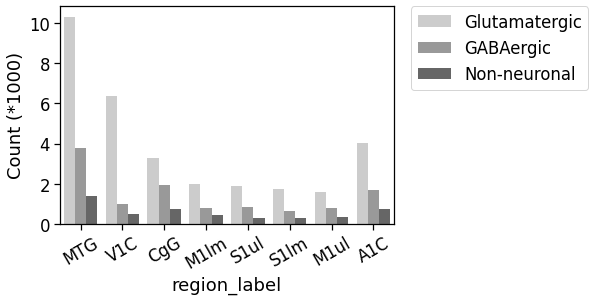

In [229]:
sns.set_context('notebook',font_scale=1.5)
g=sns.countplot(x='region_label',hue='class_label',data=cells,
              hue_order=['Glutamatergic','GABAergic','Non-neuronal'],
             palette=sns.color_palette('binary',4)[:3])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g.set_ylabel('Count (*1000)')
g.set_yticklabels([0,2,4,6,8,10])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cell_counts.pdf',
           bbox_inches='tight')

In [ ]:
palette=sns.color_palette('binary',4)[:3]

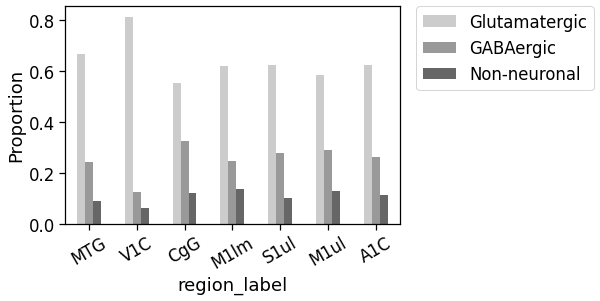

In [227]:
order = ['MTG','V1C','CgG','M1lm','S1ul','M1ul','A1C']
oorder = ['Glutamatergic','GABAergic','Non-neuronal']
g=pandas.crosstab(index=cells.region_label,columns=cells.class_label,normalize='index'
               ).loc[order,oorder].plot.bar(color=sns.color_palette('binary',4)[:3])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g.set_ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cell_prop.pdf',
           bbox_inches='tight')

In [8]:
mtx = pandas.read_csv('/Users/jacobv/Science/AllenStuff/HumanCells/matrix.csv')

In [10]:
mtx = mtx[shared]

In [14]:
# saving the genes or else they will get shuffled around
np.savez_compressed('/Users/jacobv/Science/AllenStuff/HumanCells/matrix_genes.npz',mtx.columns.values)

In [11]:
mtx.shape

(49417, 15099)

In [196]:
mtx.shape

(49417, 15099)

In [224]:
np.savez_compressed('/Users/jacobv/Science/PLS_GXP/Mouse/fullmtx.npz',mtx.values)

In [10]:
mtx = np.load('/Users/jacobv/Science/PLS_GXP/Mouse/fullmtx.npz')['arr_0']

In [15]:
#mtx = mtx.values

In [16]:
#cells = pandas.DataFrame(index = mtx.index)
cells = pandas.DataFrame(index=meta.index)
for i in range(1,4):
    print('working on component',i)
    #cells.loc[:,'C%s'%i] = np.dot(mtx.values,comps['C%s_expr'%i].values)
    cells.loc[:,'C%s'%i] = np.dot(mtx,comps.loc[shared,'C%s_expr'%i].values)

working on component 1
working on component 2
working on component 3


In [27]:
comps.loc[shared,'C1_expr'].values

array([-0.00683174,  0.00699471, -0.00016177, ...,  0.00916101,
        0.00274358, -0.01330905])

In [20]:
n_iter = 10000
nulls = pandas.DataFrame(index=range(n_iter),columns = ['C1','C2','C3'])
for c in range(1,4):
    print('Working on component',c)
    vec = np.array(comps.loc[shared,'C%s_expr'%c].values)
    for i in range(n_iter):
        if i % 1000 == 0: print('iteration %s of %s'%((i+1),n_iter))
        x = mtx[np.random.choice(len(mtx))]
        np.random.shuffle(vec)
        nulls.loc[i,'C%s'%c] = np.dot(x,vec)
        
    

Working on component 1
iteration 1 of 10000
iteration 1001 of 10000
iteration 2001 of 10000
iteration 3001 of 10000
iteration 4001 of 10000
iteration 5001 of 10000
iteration 6001 of 10000
iteration 7001 of 10000
iteration 8001 of 10000
iteration 9001 of 10000
Working on component 2
iteration 1 of 10000
iteration 1001 of 10000
iteration 2001 of 10000
iteration 3001 of 10000
iteration 4001 of 10000
iteration 5001 of 10000
iteration 6001 of 10000
iteration 7001 of 10000
iteration 8001 of 10000
iteration 9001 of 10000
Working on component 3
iteration 1 of 10000
iteration 1001 of 10000
iteration 2001 of 10000
iteration 3001 of 10000
iteration 4001 of 10000
iteration 5001 of 10000
iteration 6001 of 10000
iteration 7001 of 10000
iteration 8001 of 10000
iteration 9001 of 10000


In [21]:
distrs = {}
for c in nulls.columns:
    distrs.update({c: np.array(sorted(nulls[c].values))})

count = 0
for i,row in cells.iterrows():
    if count % 1000 == 0: print('working on %s of %s'%((count+1),len(cells)))
    for c in cells.columns[:3]:
        if row[c] < 0:
            p = len(distrs[c][distrs[c]<row[c]]) / n_iter
        else:
            p = len(distrs[c][distrs[c]>row[c]]) / n_iter
        cells.loc[i,'p_%s'%c] = p
    count+=1

working on 1 of 49417
working on 1001 of 49417
working on 2001 of 49417
working on 3001 of 49417
working on 4001 of 49417
working on 5001 of 49417
working on 6001 of 49417
working on 7001 of 49417
working on 8001 of 49417
working on 9001 of 49417
working on 10001 of 49417
working on 11001 of 49417
working on 12001 of 49417
working on 13001 of 49417
working on 14001 of 49417
working on 15001 of 49417
working on 16001 of 49417
working on 17001 of 49417
working on 18001 of 49417
working on 19001 of 49417
working on 20001 of 49417
working on 21001 of 49417
working on 22001 of 49417
working on 23001 of 49417
working on 24001 of 49417
working on 25001 of 49417
working on 26001 of 49417
working on 27001 of 49417
working on 28001 of 49417
working on 29001 of 49417
working on 30001 of 49417
working on 31001 of 49417
working on 32001 of 49417
working on 33001 of 49417
working on 34001 of 49417
working on 35001 of 49417
working on 36001 of 49417
working on 37001 of 49417
working on 38001 of 49417

In [17]:
for cue in cues:
    cells.loc[:,cue] = meta[cue].values

In [23]:
for pcol in ['p_C1','p_C2','p_C3']:
    print(pcol,'\n',cells[cells[pcol]<0.025].class_label.value_counts() /\
                    cells.class_label.value_counts(),'\n\n')

p_C1 
 Glutamatergic    0.969355
GABAergic        0.915808
Non-neuronal     0.256890
Name: class_label, dtype: float64 


p_C2 
 Glutamatergic    0.982740
GABAergic        0.736157
Non-neuronal     0.009888
Name: class_label, dtype: float64 


p_C3 
 Glutamatergic    0.059752
GABAergic        0.026288
Non-neuronal     0.009468
Name: class_label, dtype: float64 




In [26]:
for pcol in ['p_C1','p_C2','p_C3']:
    print(pcol,'\n',(cells[cells[pcol]<0.025].cluster_label.value_counts() /\
                   cells.cluster_label.value_counts()).dropna().sort_values(),'\n\n')

p_C1 
 Micro L1-6 C1QC            0.008000
Oligo L4-6 MOBP COL18A1    0.027559
Oligo L4-6 OPALIN          0.054296
VLMC L1-3 CYP1B1           0.090909
Peri L1-6 MUSTN1           0.218750
                             ...   
Inh L2-4 SST AHR           0.992701
Exc L5-6 FEZF2 CABP7       1.000000
Exc L3-5 LINC00507 SLN     1.000000
Inh L1-6 VIP RCN1          1.000000
Inh L1-2 PAX6 SCGN         1.000000
Name: cluster_label, Length: 119, dtype: float64 


p_C2 
 Oligo L4-6 OPALIN          0.005370
OPC L1-6 MYT1              0.007762
Astro L1 FGFR3 FOS         0.013333
Micro L1-6 C1QC            0.014667
Astro L1-6 FGFR3 ETNPPL    0.015528
                             ...   
Exc L4-5 RORB AIM2         1.000000
Exc L4 RORB CACNG5         1.000000
Exc L3-5 LINC00507 SLN     1.000000
Exc L3-5 FEZF2 ONECUT1     1.000000
Inh L3-6 PVALB MFI2        1.000000
Name: cluster_label, Length: 117, dtype: float64 


p_C3 
 Oligo L4-6 OPALIN        0.000597
Exc L3-4 RORB PRSS12     0.001120
Inh L4-6 SST MT

In [28]:
for i in range(1,4):
    col = 'p_C%s'%i
    cells.loc[:,'log10p_C%s'%i] = -np.log10(cells[col].values)

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
coords = pandas.read_csv('/Users/jacobv/Science/AllenStuff/HumanCells/tsne.csv')
meta.index = meta.sample_name.values
coords.index = coords.sample_name.values
shared = list(set(meta.index.values) & set(coords.index.values))
for cue in cues:
    coords.loc[shared,cue] = meta.loc[shared,cue].values

In [102]:
for cue in cues:
    cells.loc[:,cue] = meta[cue].values

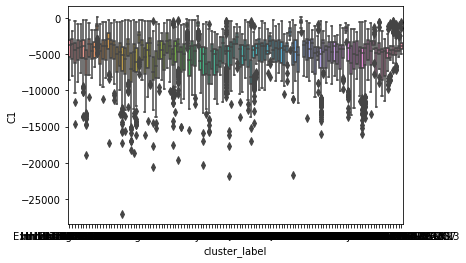

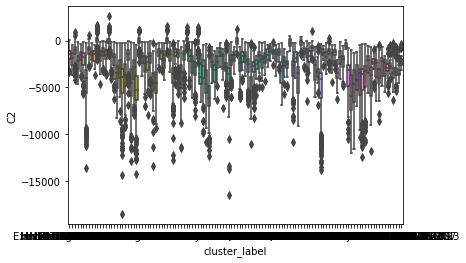

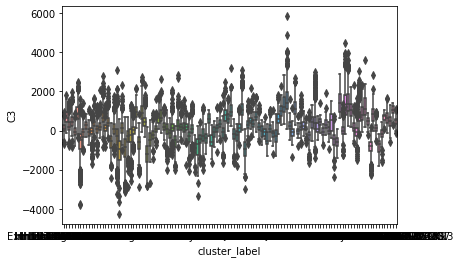

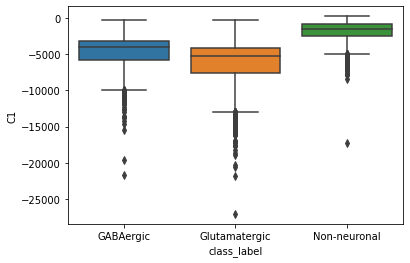

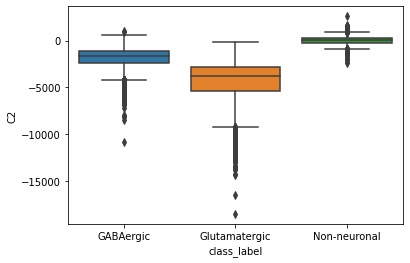

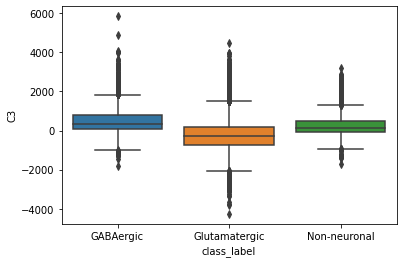

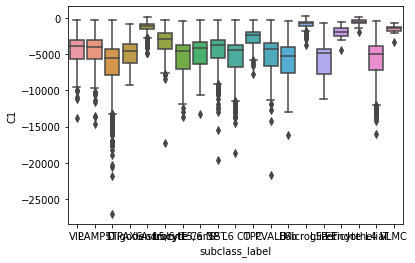

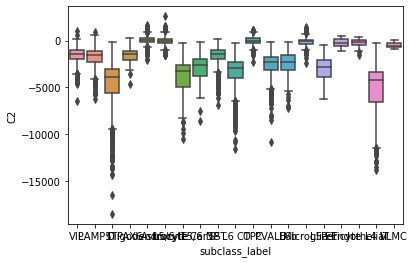

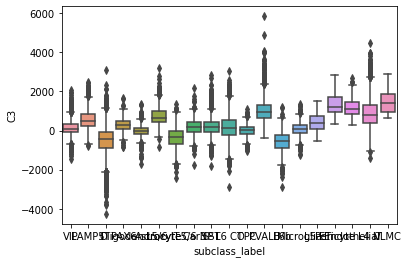

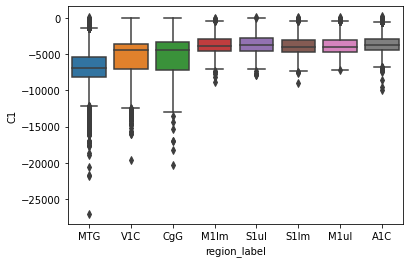

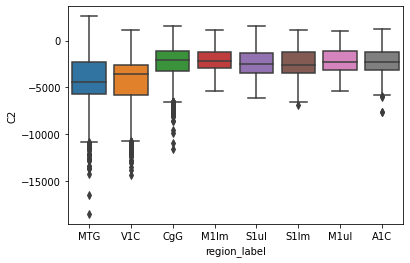

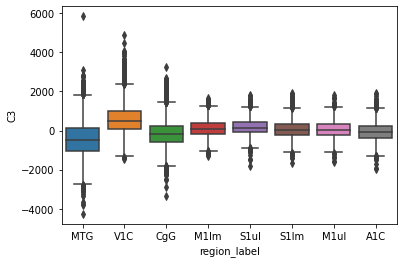

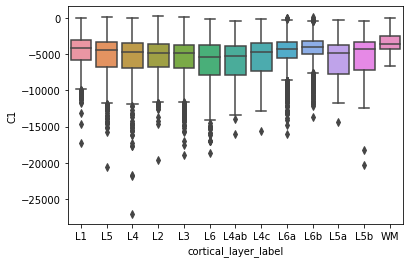

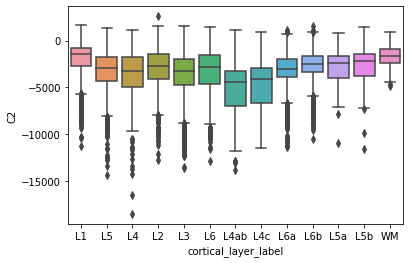

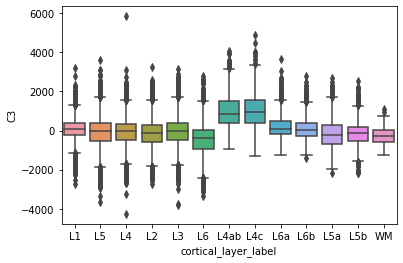

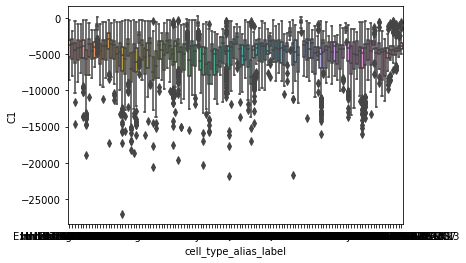

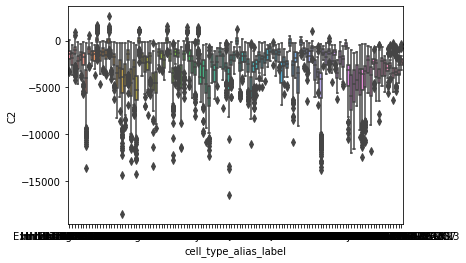

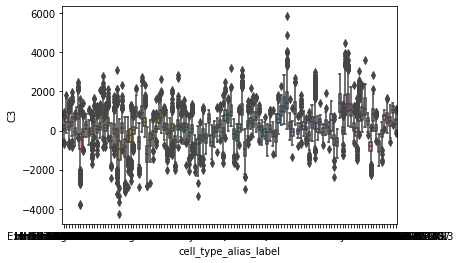

In [104]:
for cue in cues:
    for i in range(1,4):
        sns.boxplot(x=cue,y='C%s'%i,data=cells)
        plt.show()

[Text(0, 0, 'VIP'),
 Text(1, 0, 'SST'),
 Text(2, 0, 'PVALB'),
 Text(3, 0, 'LAMP5'),
 Text(4, 0, 'PAX6'),
 Text(5, 0, 'IT'),
 Text(6, 0, 'L6b'),
 Text(7, 0, 'L5/6 NP'),
 Text(8, 0, 'L5/6 IT Car3'),
 Text(9, 0, 'L6 CT'),
 Text(10, 0, 'L5 ET'),
 Text(11, 0, 'L4 IT'),
 Text(12, 0, 'Oligodendrocyte'),
 Text(13, 0, 'Astrocyte'),
 Text(14, 0, 'Microglia'),
 Text(15, 0, 'OPC'),
 Text(16, 0, 'Pericyte'),
 Text(17, 0, 'Endothelial'),
 Text(18, 0, 'VLMC')]

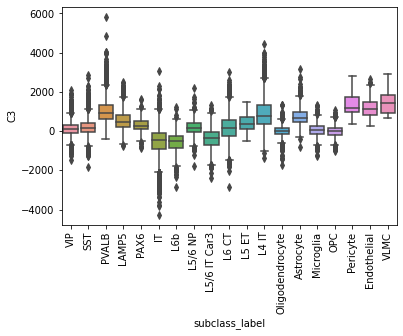

In [34]:
g=sns.boxplot(x='subclass_label',y='C3',data=cells.sort_values('class_label'))
g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [115]:
meta.class_label.unique()

array([nan, 'GABAergic', 'Glutamatergic', 'Non-neuronal'], dtype=object)

In [35]:
orders = {'GABAergic': ['PVALB','LAMP5','PAX6','VIP','SST'],
         'Glutamatergic':['L4 IT','L5 ET','L6 CT','L5/6 NP',
                           'L5/6 IT Car3','IT','L6b'],
         'Non-neuronal': ['VLMC','Pericyte','Endothelial',
                         'Astrocyte','OPC','Microglia']
        }
colors = {'GABAergic':'Blues','Glutamatergic':'Reds',
         'Non-neuronal':'Greens'}

In [ ]:
/Users/jacobv/Science/

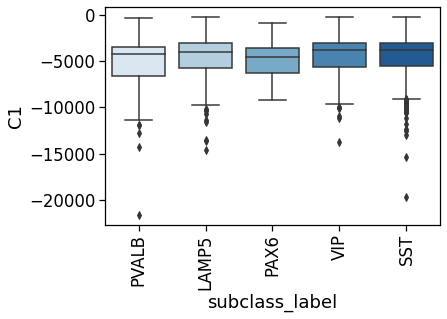

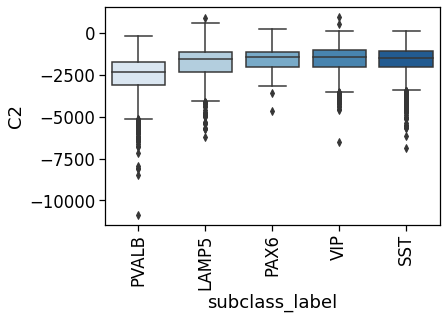

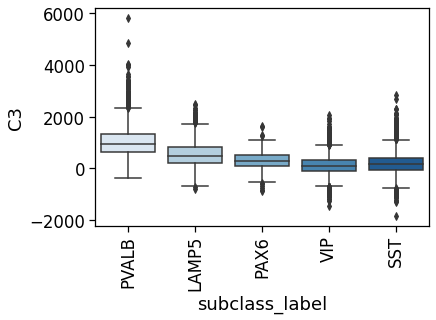

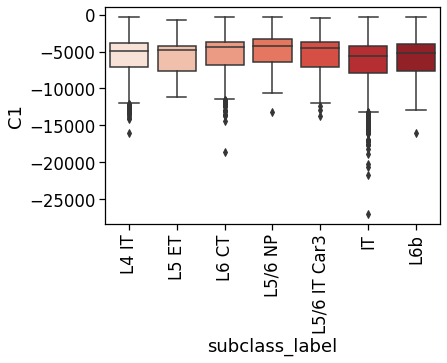

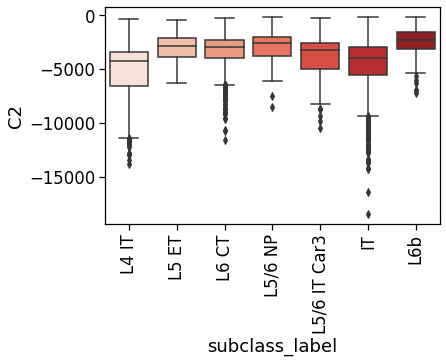

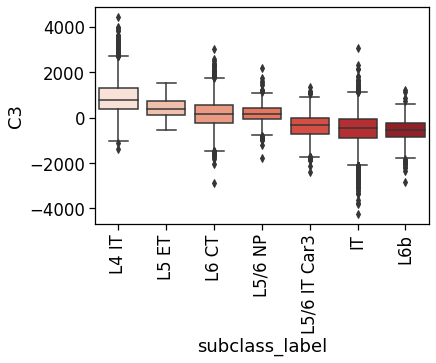

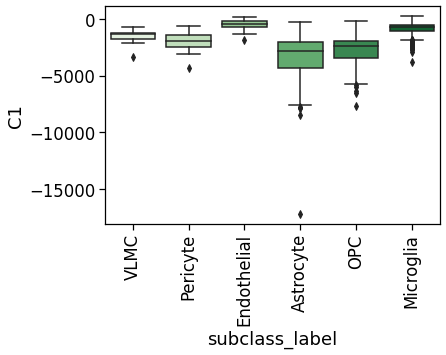

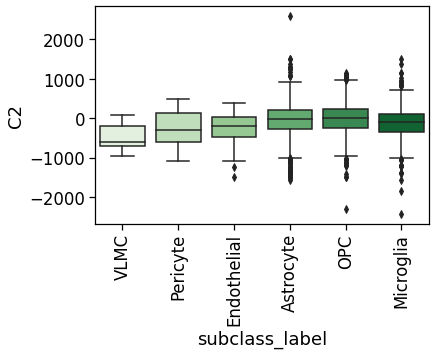

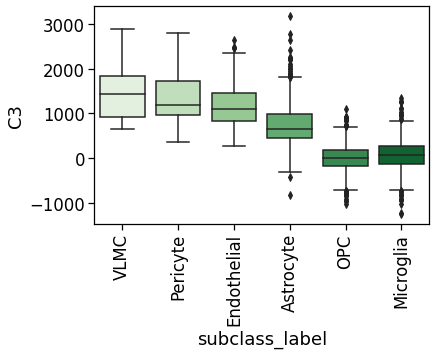

In [195]:
sns.set_context('notebook',font_scale=1.5)
for cl in meta.class_label.unique()[1:]:
    for i in range(1,4):
        g=sns.boxplot(x='subclass_label',y='C%s'%i,
                      data=cells[cells.class_label==cl],
                     order=orders[cl],palette=colors[cl])
        g.set_xticklabels(g.get_xticklabels(),rotation=90)
        plt.savefig('/Users/jacobv/Science//PLS_GXP/txfer/ManuFigs/CT_C%s_%s.pdf'%(i,cl),
                   bbox_inches='tight')
        plt.show()

In [132]:
meta.region_label.unique()

array(['MTG', 'V1C', 'CgG', 'M1lm', 'S1ul', 'S1lm', 'M1ul', 'A1C'],
      dtype=object)

In [135]:
# for region in meta.region_label.unique():
#     print(region)
#     for cl in meta.class_label.unique()[1:]:
#         for i in range(1,4):
#             g=sns.boxplot(x='subclass_label',y='C%s'%i,
#                           data=cells[(cells.class_label==cl) & \
#                                      (cells.region_label==region)],
#                          order=orders[cl],palette=colors[cl])
#             g.set_xticklabels(g.get_xticklabels(),rotation=90)
#             plt.show()

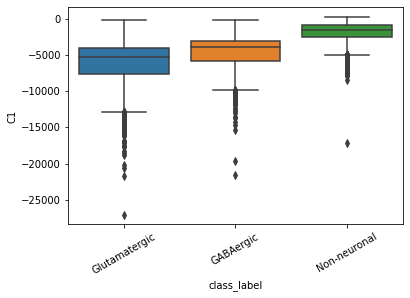

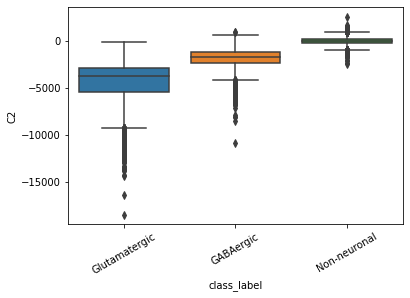

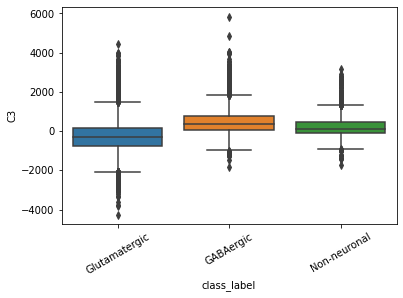

In [36]:
for i in range(1,4):
    g=sns.boxplot(x='class_label',y='C%s'%i, data=cells,
                 order=['Glutamatergic','GABAergic','Non-neuronal'])
    g.set_xticklabels(g.get_xticklabels(),rotation=30)
#     plt.savefig('/Users/jacobv/Science//PLS_GXP/txfer/ManuFigs/CT_CC_C%s.pdf'%(i),
#                    bbox_inches='tight')
    plt.show()

In [52]:
from sklearn.preprocessing import StandardScaler
for col in ['C1','C2','C3']:
    cells.loc[:,'z%s'%col] = StandardScaler().fit_transform(cells[col].values.reshape(-1,1))[:,0]

In [156]:
cells.loc[:,'ind'] = range(len(cells))
tall = cells.melt(id_vars='ind',value_vars = ['zC1','zC2','zC3'],var_name='component',value_name = 'expr')
for col in ['class_label','region_label','subclass_label']:
    tall.loc[:,col] = cells[col].tolist() * 3

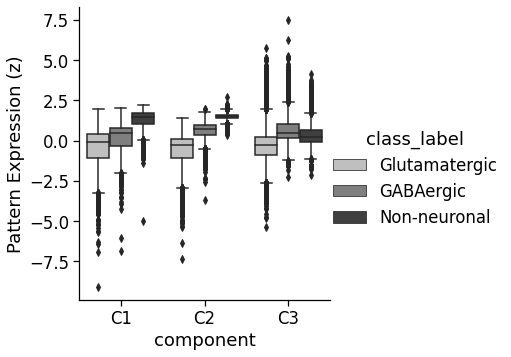

In [149]:
sns.set_context('notebook',font_scale=1.5)
g=sns.catplot(x='component',y='expr',hue='class_label',data=tall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal'],
             palette='binary')
g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cellclass.pdf',
           bbox_inches='tight')

In [120]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import cross_val_predict

lr = LogisticRegressionCV(random_state=123)
y = cells['class_label'].dropna()
X = cells.loc[y.index,['zC1','zC2']]
pred = cross_val_predict(lr,X,y,groups=y)

print(classification_report(y,pred))
print('accuracy:', accuracy_score(y,pred))
print('balanced accuracy:',balanced_accuracy_score(y,pred))

               precision    recall  f1-score   support

    GABAergic       0.75      0.71      0.73     11450
Glutamatergic       0.91      0.92      0.92     31229
 Non-neuronal       0.87      0.89      0.88      4753

     accuracy                           0.87     47432
    macro avg       0.84      0.84      0.84     47432
 weighted avg       0.87      0.87      0.87     47432

accuracy: 0.8698768763703829
balanced accuracy: 0.8426129257378129


In [119]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import cross_val_predict

lr = LogisticRegressionCV(random_state=123,)
y = cells['class_label'].dropna()
X = cells.loc[y.index,['zC1','zC2','zC3']]
pred = cross_val_predict(lr,X,y,groups=y)

print(classification_report(y,pred))
print('accuracy:', accuracy_score(y,pred))
print('balanced accuracy:',balanced_accuracy_score(y,pred))


               precision    recall  f1-score   support

    GABAergic       0.92      0.92      0.92     11450
Glutamatergic       0.98      0.98      0.98     31229
 Non-neuronal       0.90      0.91      0.91      4753

     accuracy                           0.96     47432
    macro avg       0.93      0.94      0.93     47432
 weighted avg       0.96      0.96      0.96     47432

accuracy: 0.9565904874346433
balanced accuracy: 0.9368289856755495


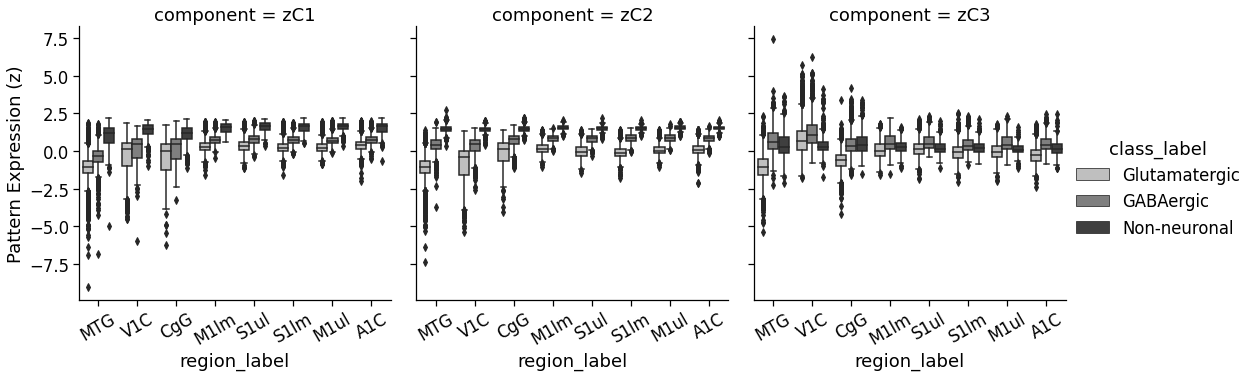

In [154]:
g = sns.catplot(x='region_label',y='expr',hue='class_label',col='component',data=tall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal'],palette='binary')
g.set_xticklabels(rotation=30)
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cellclassXregion.pdf',
           bbox_inches='tight')

In [178]:
jnk = g.axes

In [183]:
a = jnk[0][0]
a.set_ylim()

<AxesSubplot:title={'center':'component = zC1'}, ylabel='expr'>

In [188]:
cells.shape

(49417, 20)

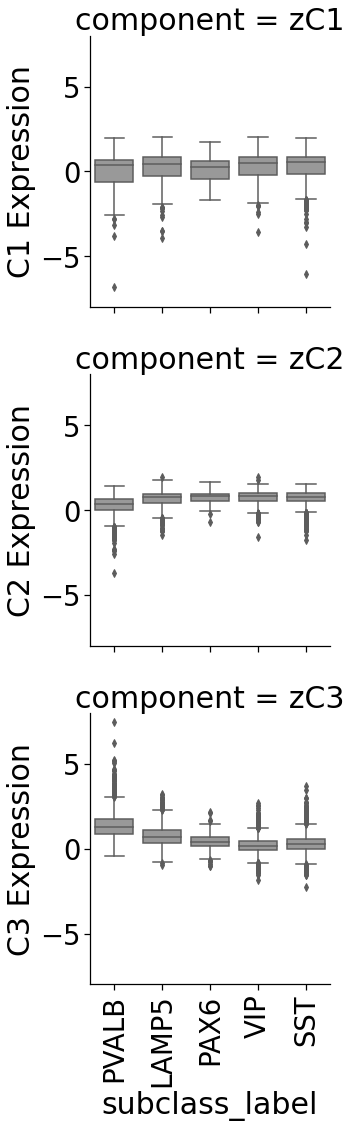

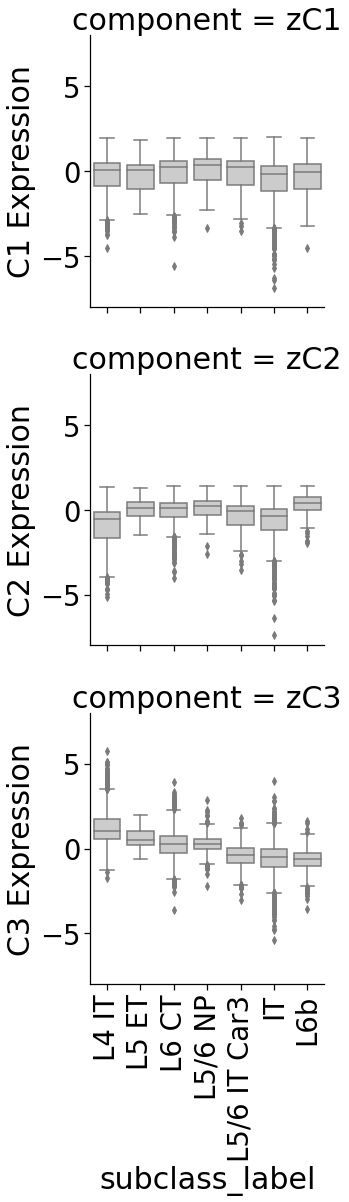

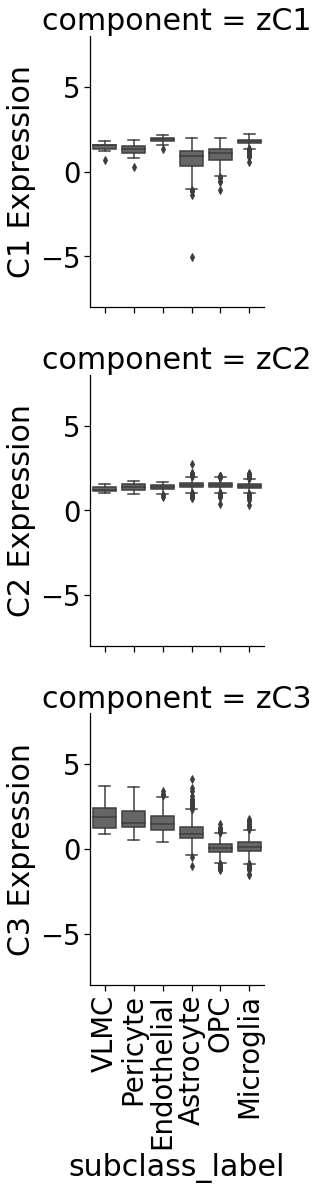

In [195]:
sns.set_context('notebook',2.5)
pal = sns.color_palette('binary',4)
orders = {'GABAergic': ['PVALB','LAMP5','PAX6','VIP','SST'],
         'Glutamatergic':['L4 IT','L5 ET','L6 CT','L5/6 NP',
                           'L5/6 IT Car3','IT','L6b'],
         'Non-neuronal': ['VLMC','Pericyte','Endothelial',
                         'Astrocyte','OPC','Microglia']
        }
colors = {'GABAergic':pal[1],'Glutamatergic': pal[0],'Non-neuronal':pal[2]}
for cl in tall.class_label.unique()[1:]:
    g = sns.catplot(x='subclass_label',y='expr',row='component',kind='box',
                data=tall[tall.class_label==cl], order=orders[cl],color=colors[cl])
    g.set_xticklabels(rotation=90)
    for i in range(3):
        g.axes[i][0].set_ylim(-8,8)
        g.axes[i][0].set_ylabel('C%s Expression'%(i+1))
    plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/CellTypes_%s.pdf'%cl,
               bbox_inches = 'tight')
    plt.show()

In [ ]:
cells.loc[:,'mean_expr'] = pandas.DataFrame(mtx).T.mean()

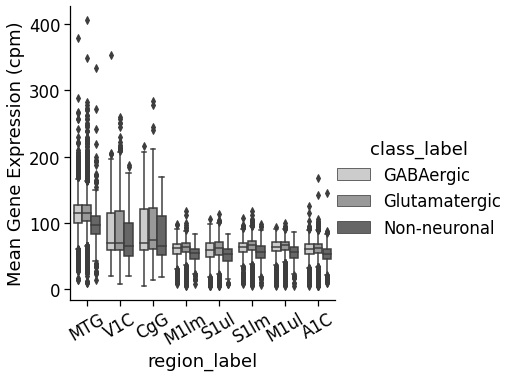

In [192]:
sns.set_context('notebook',2)
g = sns.catplot(x='region_label',y='mean_expr',hue='class_label',data=cells,kind='box',
           palette=sns.color_palette('binary',4)[:3])
g.set_xticklabels(rotation=30)
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Mean Gene Expression (cpm)')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/regional_cpm.pdf',
           bbox_inches='tight')

In [ ]:
g = sns.catplot(x='region_label',y='expr',hue='class_label',col='component',data=tall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal'],palette='binary')
g.set_xticklabels(rotation=30)
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cellclassXregion.pdf',
           bbox_inches='tight')

MTG


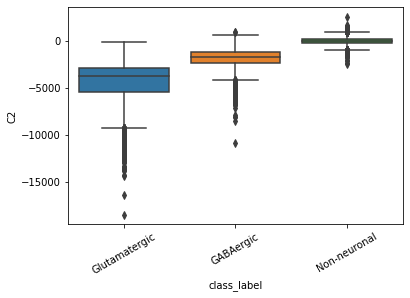

V1C


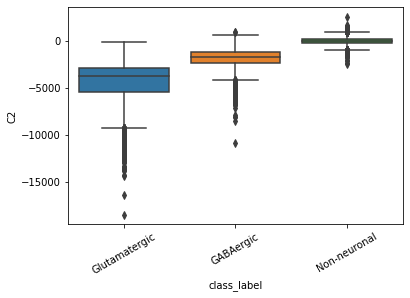

CgG


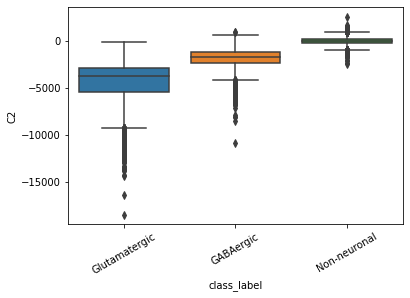

M1lm


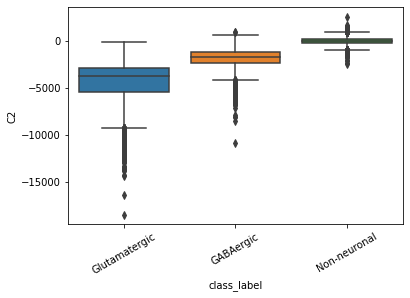

S1ul


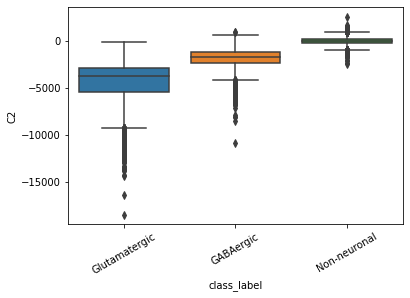

S1lm


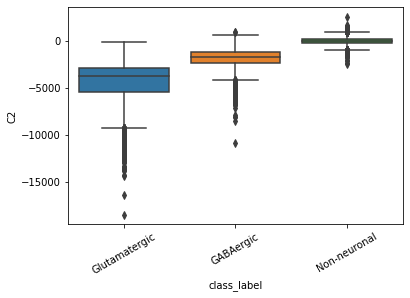

M1ul


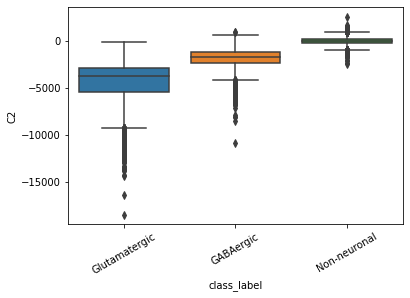

A1C


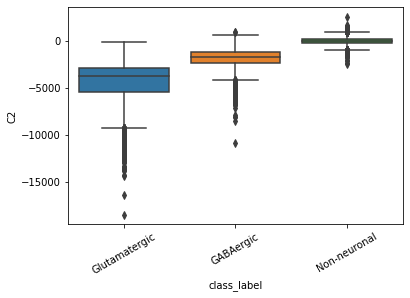

In [37]:
for reg in meta.region_label.unique():
    print(reg)
    g=sns.boxplot(x='class_label',y='C2', data=cells,
                 order=['Glutamatergic','GABAergic','Non-neuronal'])
    g.set_xticklabels(g.get_xticklabels(),rotation=30)
    plt.show()

In [ ]:
for cl in meta.class_label.unique()[1:]:
    for i in range(1,4):
        print(cl)
        g=sns.boxplot(x='cortical_layer_label',y='C%s'%i,
                      data=cells[cells.class_label==cl],
                     order = sorted(meta.cortical_layer_label.unique())
                     )
        g.set_xticklabels(g.get_xticklabels(),rotation=90)
        plt.show()

GABAergic


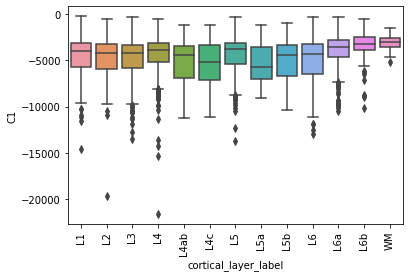

GABAergic


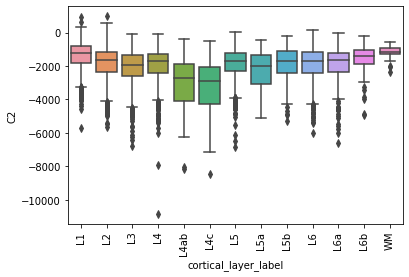

GABAergic


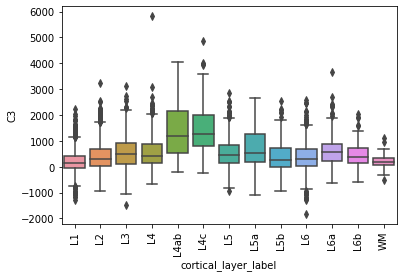

Glutamatergic


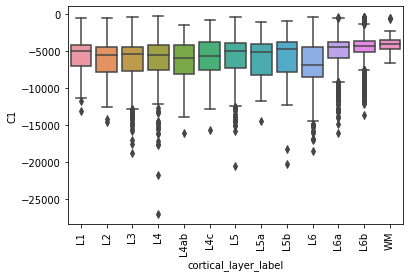

Glutamatergic


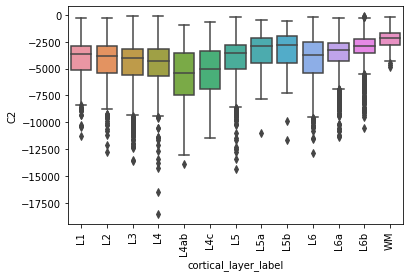

Glutamatergic


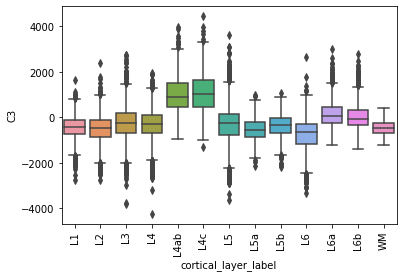

Non-neuronal


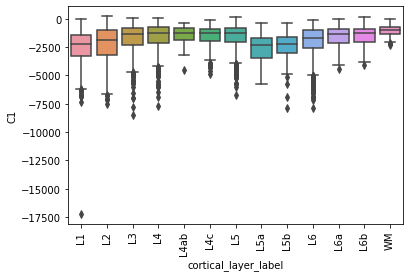

Non-neuronal


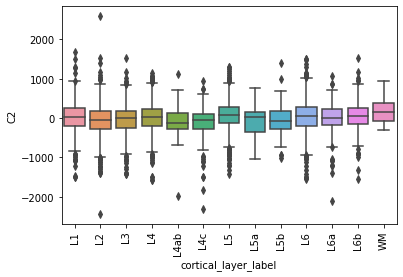

Non-neuronal


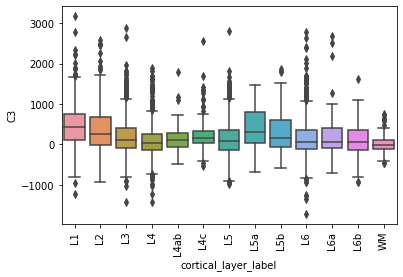

In [131]:
for cl in meta.class_label.unique()[1:]:
    for i in range(1,4):
        print(cl)
        g=sns.boxplot(x='cortical_layer_label',y='C%s'%i,
                      data=cells[cells.class_label==cl],
                     order = sorted(meta.cortical_layer_label.unique())
                     )
        g.set_xticklabels(g.get_xticklabels(),rotation=90)
        plt.show()

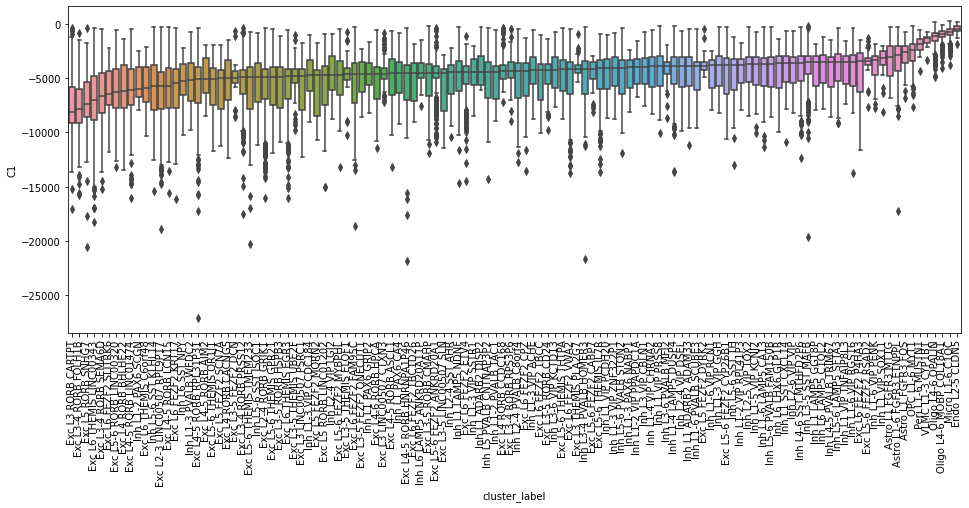

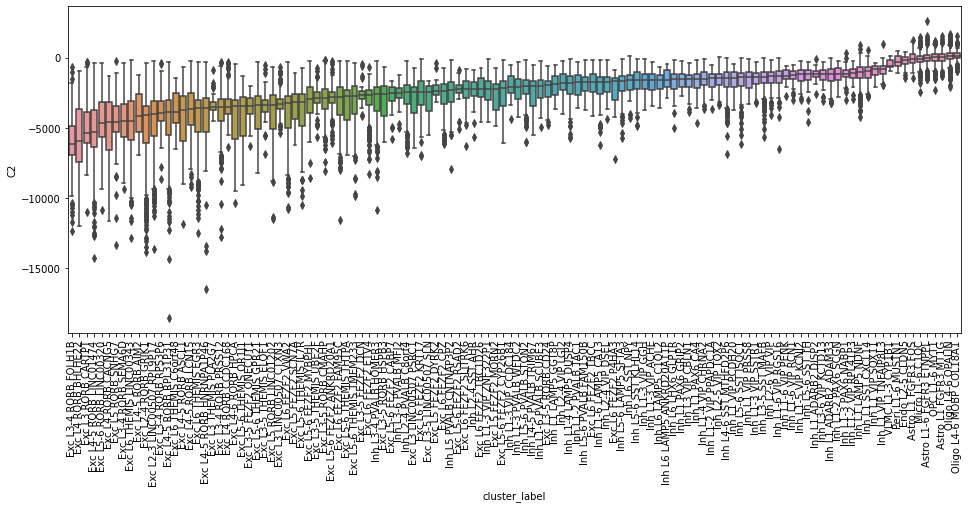

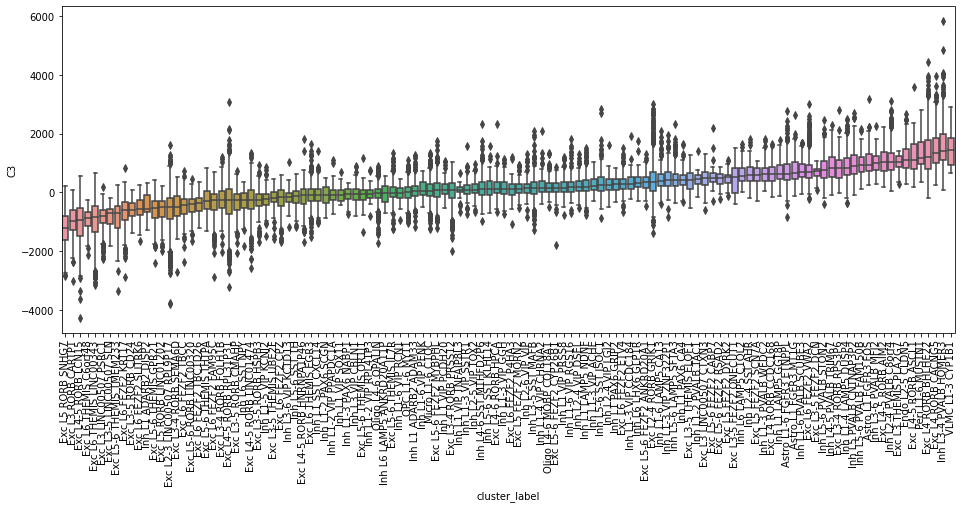

In [143]:
for i in range(1,4):
    plt.subplots(figsize=(16,6))
    order = cells.groupby('cluster_label').median().sort_values('C%s'%i
                                                               ).index
    g = sns.boxplot(x='cluster_label',y='C%s'%i,data=cells,
                   order=order)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    plt.show()

In [224]:
for i,row in cells[cells.class_label=='Glutamatergic'].iterrows():
    cells.loc[i,'exc_marker'] = row['cluster_label'].split(' ')[2]

In [235]:
cells.sort_values('C2')

,C1,C2,C3,p_C1,p_C2,p_C3,cluster_label,class_label,subclass_label,region_label,cortical_layer_label,cell_type_alias_label,exc_marker
F1S4_170329_090_H01,-947.942440,-861.096639,554.780116,0.2428,0.0502,0.2100,OPC L1-6 MYT1,Non-neuronal,OPC,MTG,L4,OPC L1-6 MYT1,NaN
F1S4_170321_058_H01,412.390803,-741.784227,251.820340,0.0860,0.0635,0.3617,OPC L1-6 MYT1,Non-neuronal,OPC,MTG,L3,OPC L1-6 MYT1,NaN
F1S4_161026_008_A01,-646.055028,-725.538563,324.879419,0.3729,0.0653,0.3158,Inh L1-3 PVALB WFDC2,GABAergic,PVALB,MTG,L2,Inh L1-3 PVALB WFDC2,NaN
F2S4_170531_107_H01,526.396707,-693.733694,1290.164827,0.0658,0.0691,0.0548,Micro L1-6 C1QC,Non-neuronal,Microglia,CgG,L6,Micro L1-6 C1QC,NaN
F1S4_170517_025_H01,-2.791172,-585.817924,146.656260,0.7704,0.0848,0.4276,OPC L1-6 MYT1,Non-neuronal,OPC,V1C,L3,OPC L1-6 MYT1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F1S4_170420_118_H01,-1235.445827,2751.844714,-345.326780,0.1616,0.0118,0.2542,Oligo L4-6 OPALIN,Non-neuronal,Oligodendrocyte,MTG,L3,Oligo L4-6 OPALIN,NaN
F1S4_170118_149_H01,1000.290342,2875.055426,107.395420,0.0229,0.0090,0.4534,Astro L1-6 FGFR3 ETNPPL,Non-neuronal,Astrocyte,MTG,L6,Astro L1-6 FGFR3 ETNPPL,NaN
F1S4_170329_090_G01,-729.121854,2929.519707,153.565374,0.3297,0.0087,0.4224,Exc L4-5 RORB HNRNPA1P46,Glutamatergic,IT,MTG,L4,Exc L4-5 RORB HNRNPA1P46,RORB
F1S4_170125_096_B01,-486.889399,2995.588658,979.498829,0.4588,0.0080,0.0980,Exc L4-5 RORB RPL31P31,Glutamatergic,IT,MTG,L4,Exc L4-5 RORB RPL31P31,RORB


In [153]:
cells.index = meta.index

r = x (C1)

g = y (C2)

b = z (C3)

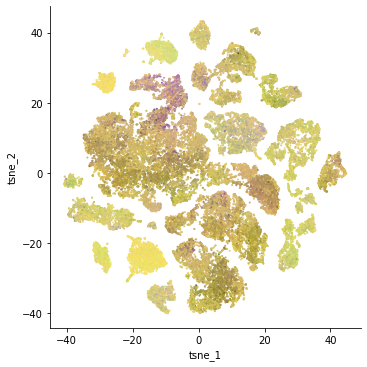

In [155]:
from sklearn.preprocessing import MinMaxScaler
shared=list(set(cells.index) & set(coords.index))
rgb_conv = MinMaxScaler().fit_transform(cells.loc[shared,['C1','C2','C3']]
                                       ).round(3)
sns.lmplot(x='tsne_1',y='tsne_2',data=coords.loc[shared],fit_reg=False,
           scatter_kws={'color':rgb_conv,'s':1})

<AxesSubplot:ylabel='Count'>

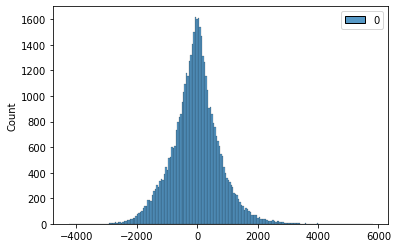

In [184]:
jnk = cells.loc[shared,'C3'].values.reshape(-1,1)
scaled_sg = MinMaxScaler().fit_transform(jnk)[:,0]
#jnk[jnk<-12000] = -12000
sns.histplot(jnk)

working on C1


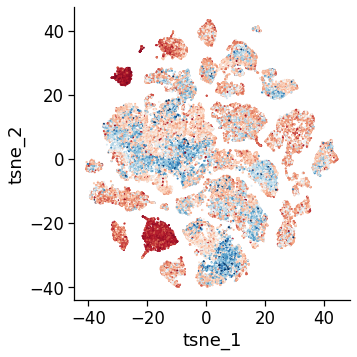

working on C2


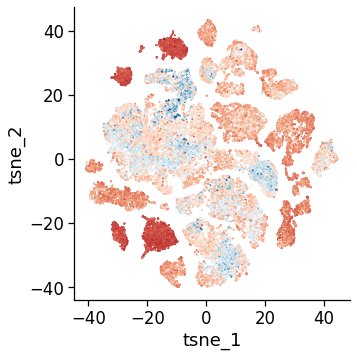

working on C3


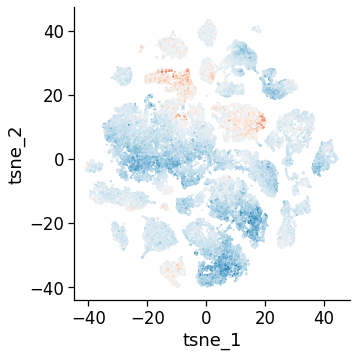

In [207]:
from matplotlib import colors as mplc
vals = np.zeros((len(shared),3))
cutoff = {'C1':-12000,'C2':-10000,'C3':None}
cmap = sns.color_palette('RdBu_r',as_cmap=True)
for c,cut in cutoff.items():
    print('working on',c)
    jnk = cells.loc[shared,c].values.reshape(-1,1)
    if cut:
        jnk[jnk<-12000] = -12000
    scaled_sg = MinMaxScaler().fit_transform(jnk)[:,0]
    vals[:,int(c[-1])-1] = scaled_sg
    norm = mplc.Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    g = sns.lmplot(x='tsne_1',y='tsne_2',data=coords.loc[shared],
                   fit_reg=False, scatter_kws={"s": 1,'color':cscale},
                      palette='RdBu_r')
    plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/CT_TSNE_%s.png'%(c),
                   bbox_inches='tight')
    plt.show()

r = x (C1)

g = y (C2)

b = z (C3)

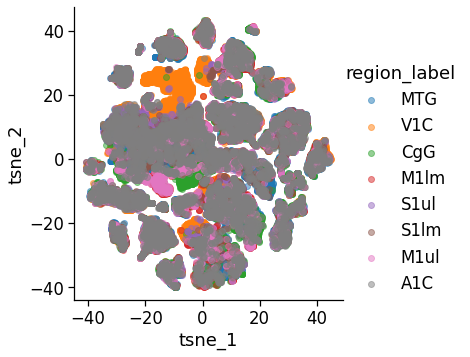

In [219]:
sns.lmplot(x='tsne_1',y='tsne_2',hue='region_label',data=coords,
          fit_reg=False,scatter_kws={'s':1, 'alpha':0.5})
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/CT_TSNE_Region_labels.pdf',
                   bbox_inches='tight')
# sns.lmplot(x='tsne_1',y='tsne_2',hue='region_label',data=coords,
#           fit_reg=False,scatter_kws={'alpha':0.5})
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/CT_TSNE_Region.png',
#                    bbox_inches='tight')

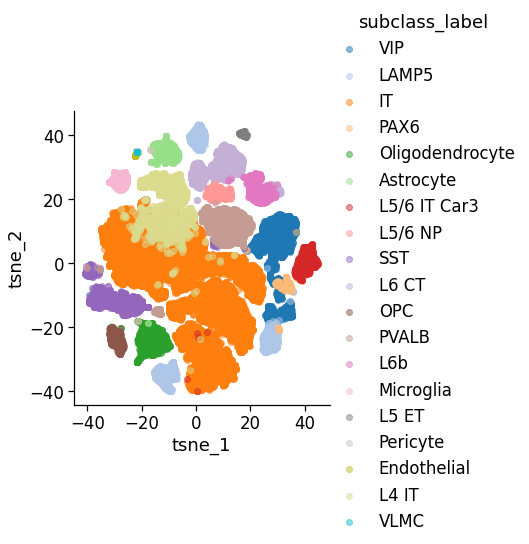

In [220]:
# sns.lmplot(x='tsne_1',y='tsne_2',hue='subclass_label',data=coords,
#           fit_reg=False,scatter_kws={'s':5, 'alpha':0.5},palette='tab20')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/CT_TSNE_CellClass.png',
#                    bbox_inches='tight')
sns.lmplot(x='tsne_1',y='tsne_2',hue='subclass_label',data=coords,
          fit_reg=False,scatter_kws={'alpha':0.5},palette='tab20')
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/CT_TSNE_CellClass_labels.pdf',
                   bbox_inches='tight')

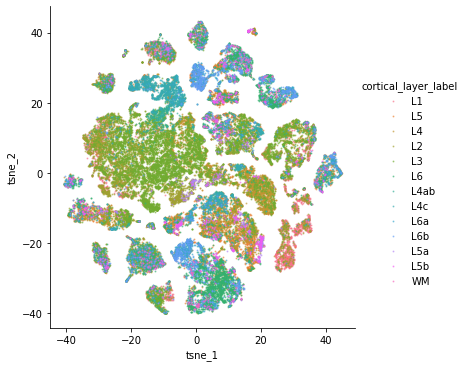

In [100]:
sns.lmplot(x='tsne_1',y='tsne_2',hue='cortical_layer_label',data=coords,
          fit_reg=False,scatter_kws={'s':1, 'alpha':0.5})


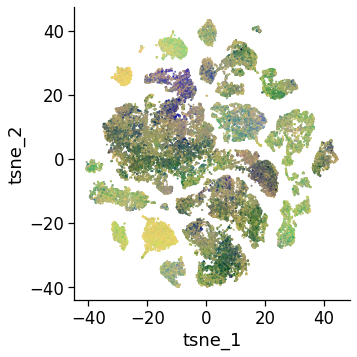

In [206]:
sns.lmplot(x='tsne_1',y='tsne_2',data=coords.loc[shared],fit_reg=False,
           scatter_kws={'color':vals,'s':1})
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/CT_TSNE_Mix.png',
                   bbox_inches='tight')

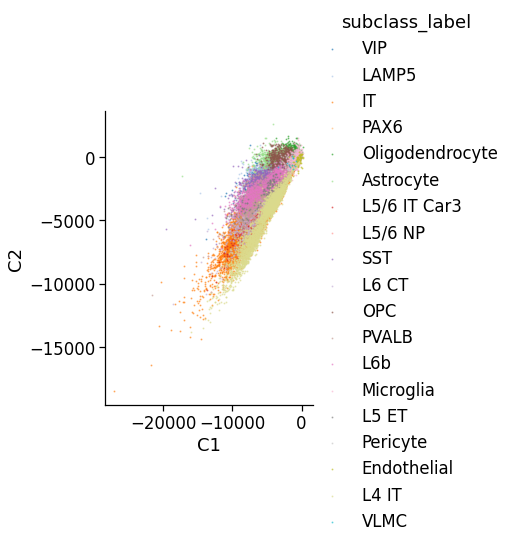

In [211]:
sns.lmplot(x='C1',y='C2',hue='subclass_label',data=cells,
          fit_reg=False,scatter_kws={'s':1, 'alpha':0.5},palette='tab20')

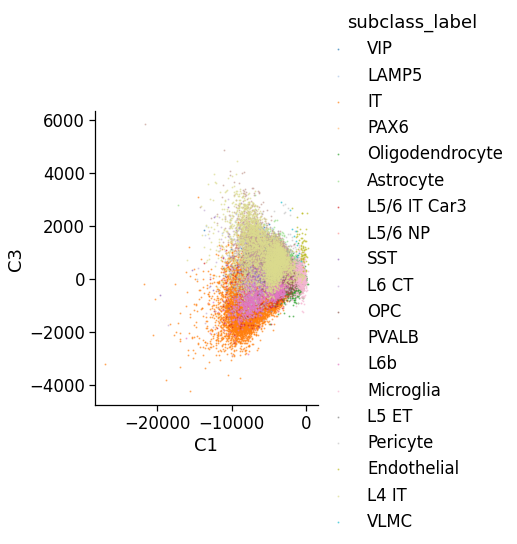

In [210]:
sns.lmplot(x='C1',y='C3',hue='subclass_label',data=cells,
          fit_reg=False,scatter_kws={'s':1, 'alpha':0.5},palette='tab20')

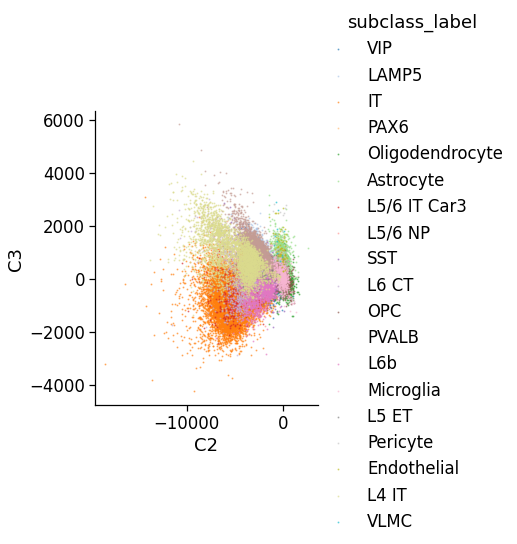

In [212]:
sns.lmplot(x='C2',y='C3',hue='subclass_label',data=cells,
          fit_reg=False,scatter_kws={'s':1, 'alpha':0.5},palette='tab20')

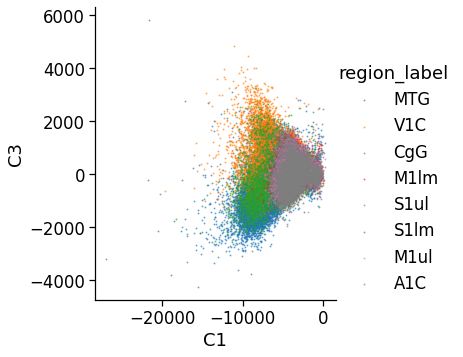

In [217]:
sns.lmplot(x='C1',y='C3',hue='region_label',data=cells,
          fit_reg=False,scatter_kws={'s':1, 'alpha':0.5},palette='tab10')

# PCs

In [234]:
cells.shape

(49417, 9)

In [239]:
mtx

,DDX27,TEX29,PRUNE2,DLST,OTX1,CHST14,PSMB1,PHACTR2,PIP5K1C,CCDC82,...,LRP4,SPHK2,MCM9,SEPT10,HIST1H3G,PFDN2,CRYL1,CYP4V2,CHSY1,NEFL
0,0,0,0,0,0,0,0,0,40,93,...,0,0,2,0,0,0,333,0,115,0
1,0,0,1,0,0,0,298,0,61,0,...,0,0,46,0,0,1,0,0,0,0
2,0,0,656,47,0,0,10,1,0,9,...,0,189,1,0,0,51,0,145,0,0
3,328,0,4,5,0,0,503,402,0,109,...,1,57,1,0,0,0,2,0,12,0
4,0,0,373,7,0,0,324,0,2,266,...,323,0,1,1,0,0,57,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49412,0,0,0,0,0,0,0,0,0,0,...,188,0,0,231,0,0,347,0,0,0
49413,1,0,102,0,0,0,0,182,23,78,...,0,0,0,0,0,60,0,138,1,0
49414,0,0,2,0,0,0,177,0,0,99,...,0,59,0,0,0,108,0,0,0,0
49415,131,0,1036,0,0,0,39,0,0,461,...,65,0,0,1,0,150,1,0,0,0


In [240]:
cells.loc[:,'orig_index'] = range(len(cells))

In [244]:
mtx.loc[cells[cells.subclass_label=='LAMP5'].orig_index.values].shape

(2434, 15099)

In [245]:
cellmat = mtx.values[cells[cells.subclass_label=='LAMP5'].orig_index.values]

In [248]:
from sklearn.decomposition import PCA


In [ ]:
pcamod = PCA()

In [249]:
x = 'sub-20842880_ses-1_acq-MG20120501grefieldmappinge1VARIANTMultibandAccelerationFactor_magnitude1.nii.gz'


In [252]:
x.encode()

b'sub-20842880_ses-1_acq-MG20120501grefieldmappinge1VARIANTMultibandAccelerationFactor_magnitude1.nii.gz'

# Dev Single Cell

In [70]:
import pyreadr

In [71]:
rdata = pyreadr.read_r('/Users/jacobv/Science/PLS_GXP/CellsnLayers/DevCells/Sestan.fetalHuman.Psychencode.Rdata')

In [72]:
rdata.keys()

odict_keys(['count2', 'cpm2', 'meta2'])

In [73]:
devmeta = rdata['meta2']

In [74]:
devmtx = rdata['cpm2']

In [75]:
devmtx.loc[:,'gene_symbol'] = [x.split('|')[1] for x in devmtx.index]

In [76]:
dups = []
dind = []
catch = []
for i,row in devmtx.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)
        
#devmtx = devmtx.drop(dind)

In [77]:
devmtx = devmtx.drop(dind)
devmtx.shape

(57996, 763)

In [78]:
devmtx.index = devmtx.gene_symbol.values
devmtx.drop('gene_symbol',axis=1,inplace=True)

In [79]:
devshared = set(comps.index) & set(devmtx.index)

In [80]:
len(devshared)

14524

In [123]:
devmtx.loc[devshared].shape

(14524, 762)

In [81]:
devmtx = devmtx.loc[devshared]

In [82]:
#cells = pandas.DataFrame(index = mtx.index)
devcells = pandas.DataFrame(index=devmeta.index)
for i in range(1,4):
    print('working on component',i)
    #cells.loc[:,'C%s'%i] = np.dot(mtx.values,comps['C%s_expr'%i].values)
    devcells.loc[:,'C%s'%i] = np.dot(devmtx.loc[devshared].T,comps.loc[devshared,'C%s_expr'%i].values)

working on component 1
working on component 2
working on component 3


In [83]:
for col in devmeta.columns:
    devcells.loc[:,col] = devmeta[col].values

In [84]:
for i,row in devcells.iterrows():
    ctype = row['ctype']
    if 'Ex' in ctype:
        devcells.loc[i,'cclass'] = 'Glutamatergic'
    elif 'In' in ctype:
        devcells.loc[i,'cclass'] = 'GABAergic'
    elif 'Nas' in ctype:
        devcells.loc[i,'cclass'] = 'Nas'
    elif 'NEPRGC' in ctype:
        devcells.loc[i,'cclass'] = 'NEPRGC'
    else:
        devcells.loc[i,'cclass'] = 'Non-neuronal'

In [88]:
devcells.ctype.value_counts().sort_index()

Astro         49
Endo          29
ExN1          81
ExN2          10
ExN3          18
IPC1         143
IPC2          27
InN1          18
InN2          21
Microglia     11
NEPRGC1       57
NEPRGC2       31
NEPRGC3       16
NEPRGC4       20
NasN1         85
NasN2         23
NasN3         23
NasN4         14
NasN5         11
NasN6         15
OPC1          13
OPC2          20
Oligo         10
Pericyte      17
Name: ctype, dtype: int64

In [91]:
for i,row in devcells.iterrows():
    devcells.loc[i,'ctype_2'] = ['%s_%s'%(row['cclass'],row['ctype'])]

In [123]:
from sklearn.preprocessing import StandardScaler
for col in ['C1','C2','C3']:
    devcells.loc[:,'z%s'%col] = StandardScaler().fit_transform(devcells[col].values.reshape(-1,1))[:,0]

component 1


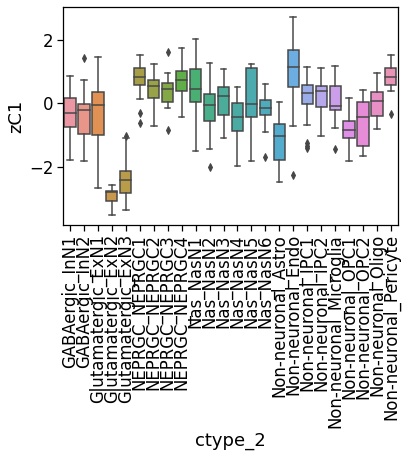

component 2


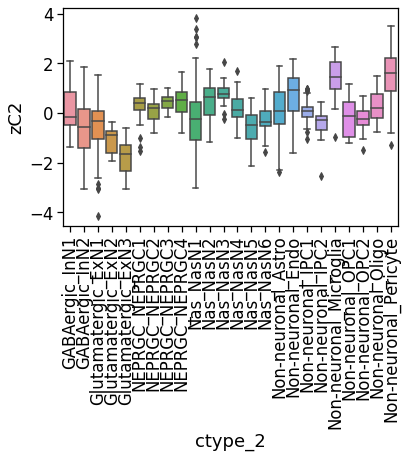

component 3


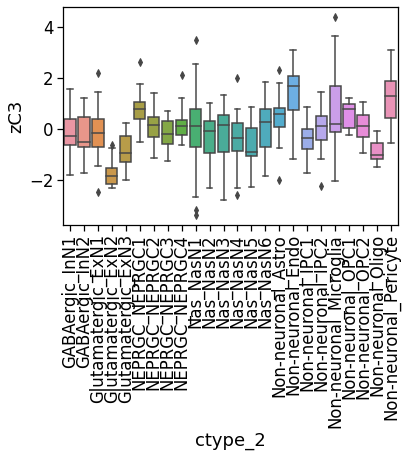

In [125]:
for i in range(1,4):
    print('component',i)
    g=sns.boxplot(x='ctype_2',y='zC%s'%i,data=devcells,
                 order=sorted(devcells.ctype_2.unique()))
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    plt.show()

In [236]:
devcells.loc[:,'ind'] = range(len(devcells))
devtall = devcells.melt(id_vars='ind',value_vars=['zC1','zC2','zC3'], var_name='component',value_name='expr')
devtall.loc[:,'cclass'] = devcells.cclass.tolist() * 3
devtall.loc[:,'AgePCW'] = [int(x.split('P')[0]) for x in devcells.Age] * 3

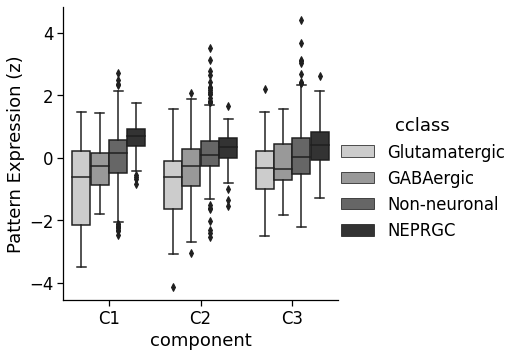

In [155]:
sns.set_context('notebook',font_scale=1.5)
g=sns.catplot(x='component',y='expr',hue='cclass',data=devtall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal','NEPRGC'],
             palette='binary')
g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/DEVcellclass.pdf',
           bbox_inches='tight')

component 1


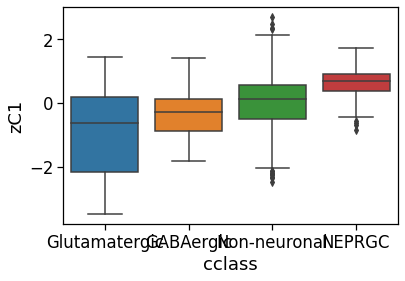

component 2


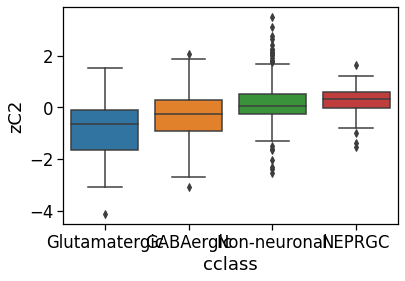

component 3


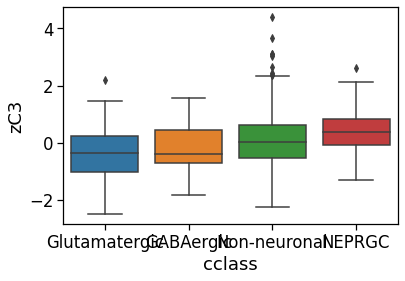

In [126]:
for i in range(1,4):
    print('component',i)
    sns.boxplot(x='cclass',y='zC%s'%i,data=devcells,
               order=['Glutamatergic','GABAergic','Non-neuronal','NEPRGC'])
    plt.show()

component 1


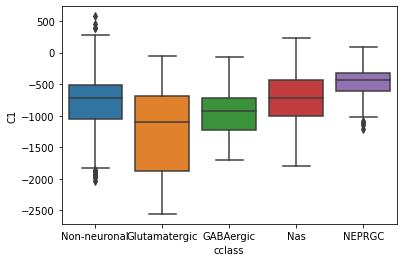

component 2


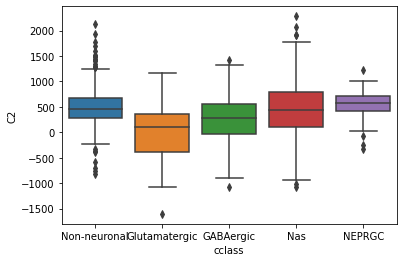

component 3


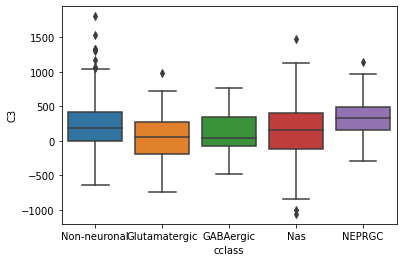

In [142]:
for i in range(1,4):
    print('component',i)
    sns.boxplot(x='cclass',y='C%s'%i,data=devcells)
    plt.show()

In [140]:
lr = LogisticRegressionCV(random_state=123,)
y = devcells[devcells.isin(['Glutamatergic','GABAergic','Non-neuronal'])]['cclass'].dropna()
X = devcells.loc[y.index,['zC1','zC2','zC3']]
pred = cross_val_predict(lr,X,y,groups=y)

print(classification_report(y,pred))
print('accuracy:', accuracy_score(y,pred))
print('balanced accuracy:',balanced_accuracy_score(y,pred))


               precision    recall  f1-score   support

    GABAergic       0.00      0.00      0.00        39
Glutamatergic       0.62      0.39      0.47       109
 Non-neuronal       0.75      0.94      0.84       319

     accuracy                           0.73       467
    macro avg       0.46      0.44      0.44       467
 weighted avg       0.66      0.73      0.68       467

accuracy: 0.7323340471092077
balanced accuracy: 0.44191999079692845


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:
devcells.Age.value_counts()

8PCW     205
19PCW    196
6PCW     119
16PCW    115
5PCW      74
20PCW     53
Name: Age, dtype: int64

In [243]:
devcells.cclass.value_counts()

Non-neuronal     319
Nas              171
NEPRGC           124
Glutamatergic    109
GABAergic         39
Name: cclass, dtype: int64

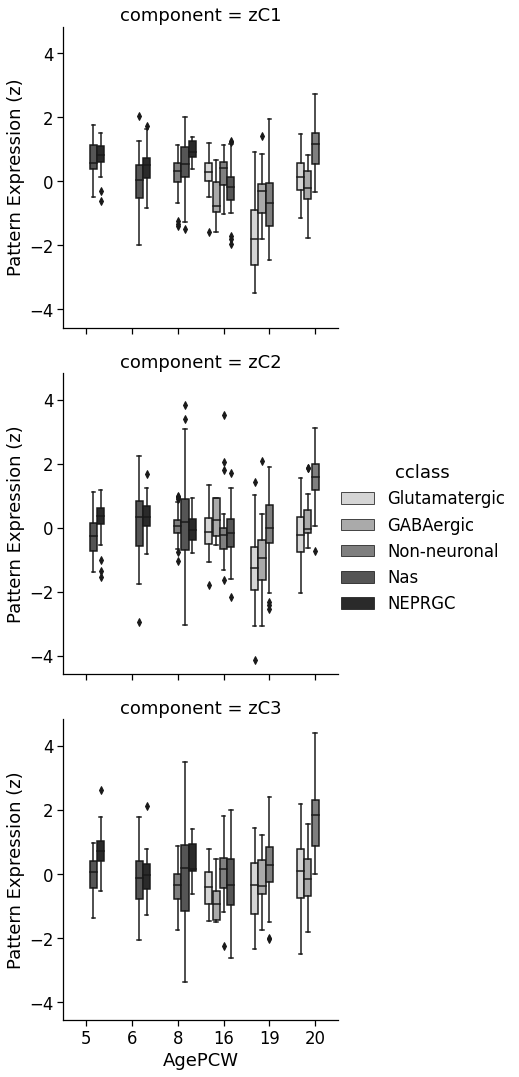

In [240]:
sns.set_context('notebook',font_scale=1.5)
g=sns.catplot(x='AgePCW',y='expr',hue='cclass',data=devtall,kind='box',row='component',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal','Nas','NEPRGC'],
             palette='binary')
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
# plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/DEVcellclass.pdf',
#            bbox_inches='tight')